### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import logging
import subprocess
import os
from datetime import datetime
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingWarmRestarts
import torchvision
from torchvision import models
from apex import amp

from torch_lr_finder import LRFinder

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PROJ_PATH,
                              PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset, PatchTrainDataset, H5PatchDataset, SeqenceRandomSampler

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix, text_classes_preds)

# Nets
from chestxray.nets import TinyV2ConvNet, freeze_botom, PatchModel, PatchEnetModel, PatchBiTModel, TilesModel, AttentionModel
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)
# Losses
from chestxray.losses import LabelSmoothSoftmaxCEV1, TopkCrossEntropy, TopkBCEWithLogitsLoss

# Optim
from chestxray.optimizers import RAdam

# Schedulers
from chestxray.schedulers import CosineAnnealingWarmUpRestarts

# postproc
from chestxray.postprocess import OptimizedRounder

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Fix Random Seed

In [6]:
seed_torch()

In [7]:
# torch.backends.cudnn.benchmark = True

### Load Data

In [8]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [9]:
TRAIN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
dtypes: int64(1), object(3)
memory usage: 331.9+ KB


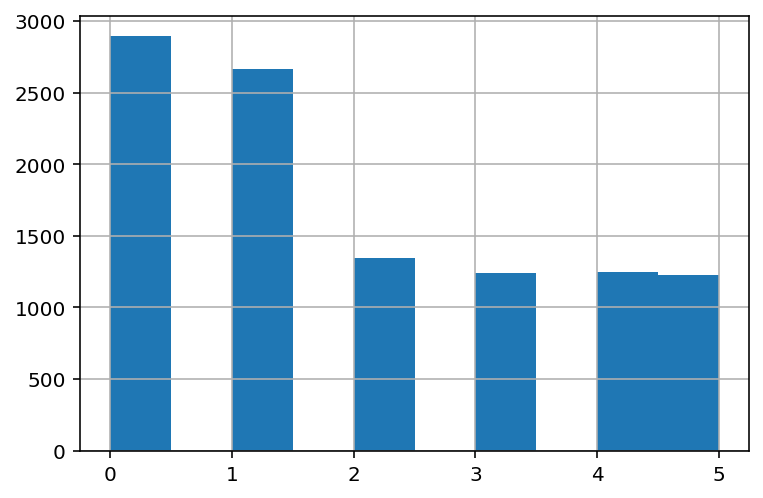

In [10]:
_ = TRAIN_DF[CFG.target_col].hist()

### Define Global Variables

In [11]:
if CFG.debug:
    EXP_NAME = "debug"
    writer = SummaryWriter(f"runs_v1/{EXP_NAME}")
    print(f"Start experiment: {EXP_NAME}")
else:
    if not CFG.resume:
        now = datetime.now()
        EXP_NAME = now.strftime("%d-%m-%Y-%H-%M")
        print(f"Start experiment: {EXP_NAME}")

        writer = SummaryWriter(f"runs_v1/{EXP_NAME}")
    else:
        # if resume should define from what to start
        PREV_NAME = CFG.prev_exp
        writer = SummaryWriter(f"runs_v1/{PREV_NAME}_{CFG.stage}")
        print(f"Continue experiment: {PREV_NAME}_{CFG.stage}")

Start experiment: 10-07-2020-23-06


In [12]:
# Set logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

log_format = logging.Formatter('%(message)s')
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(log_format)
logger.handlers = [stream_handler]
# add logging handler to save training to the file
NAME = EXP_NAME if not CFG.resume else PREV_NAME
log_fname = f"{PROJ_PATH/'logs'}/{NAME}.log"
file_handler = logging.FileHandler(log_fname, mode="a")
file_handler.setFormatter(log_format)
logger.handlers.append(file_handler)

In [13]:
LOSSES = {
    "cce" : nn.CrossEntropyLoss(),
    "mse" : nn.MSELoss(),
    "ls_soft_ce" : LabelSmoothSoftmaxCEV1(),
    "ohem" : TopkCrossEntropy(),
    "bce" : TopkBCEWithLogitsLoss() if CFG.ohem else nn.BCEWithLogitsLoss(),
}

In [14]:
# key - string, value - tuple(sceduler, if it epoch type)
epoch_type = True
SCHEDULERS = {
    "reduce_on_plateau" : (ReduceLROnPlateau, epoch_type),
    "one_cycle": (OneCycleLR, not epoch_type),
    "cawr": (CosineAnnealingWarmUpRestarts, not epoch_type),
    "none": (None, None)
}

In [15]:
# schedulers
def get_scheduler(optimizer,train_dataloader, schedule_type=CFG.schedule_type, resume=False):
    assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
    if schedule_type == "reduce_on_plateau":
        return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp if not resume else CFG.rlopp + 2, verbose=True), 
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "one_cycle":
        return (SCHEDULERS[schedule_type][0](optimizer, max_lr=[CFG.lr, CFG.lr*10] if CFG.finetune == "1stage" else CFG.lr,
                                             steps_per_epoch=int(len(train_dataloader) / CFG.accum_step), epochs=CFG.epoch, pct_start=1/CFG.epoch, 
                                             cycle_momentum=False, final_div_factor=CFG.oc_final_div_factor),
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "cawr":
        return (SCHEDULERS[schedule_type][0](optimizer, T_0=CFG.cawr_T_0, T_mult=CFG.cawr_T_mult, eta_max=CFG.lr, T_up=CFG.cawr_T_up, gamma=CFG.cawr_gamma),
                SCHEDULERS[schedule_type][1])
    else:
        return (SCHEDULERS[schedule_type][0],
                SCHEDULERS[schedule_type][1])

### Train Eval Loop

In [16]:
# Train Eval Loop
def train_eval_loop(
    train_dataloader,
    val_dataloader,
    model,
    optimizer,
    criterion,
    accum_step=CFG.accum_step,
    checkpoint=False,
    num_epochs=CFG.epoch,
    device=device,
    tb_tag="",
    model_name="debug",
):
    """Split it into the set of inner functions to siplify the loop itself"""
    # Inner Functions
    # write to TensorBoard helpers
    def weights_to_tb(step=0):
        conv1_weight = list(model.parameters())[0].data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight.float(), normalize=True)
        writer.add_image(
            tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=step
        )

    def input_img_to_tb(inputs, step):
        img = reverse_show_img(inputs[0], denorm=True)
        writer.add_image(
            tag=f"Input Image {tb_tag}",
            img_tensor=img,
            global_step=step,
            dataformats="HWC",
        )
        del img

    def preds_to_tb(outputs, inputs, labels, step):
        figure = plot_classes_preds(
            outputs.to("cpu"), inputs.to("cpu"), labels.to("cpu")
        )
        writer.add_figure(
            tag=f"Actuals vs Predictions {tb_tag}", figure=figure, global_step=step
        )

    def text_preds_to_tb(outputs, labels, step):
        preds, targs = compute_preds(outputs, labels)
        preds_text = f"targs: {targs}, preds: {preds}"
        writer.add_text(
            f"Actuals vs Predictions {tb_tag}", preds_text, global_step=step
        )

    def metrics_to_tb(mode, train_loss, train_score, val_loss, val_score, step):
        writer.add_text(
            f"On best {mode} save:",
            f"tr_loss: {train_loss:.4f}, tr_qwk: {train_score:.4f}, val_loss: {val_loss:.4f}, val_qwk: {val_score:.4f}",  # noqa
            global_step=step,
        )

    def conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, step):
        writer.add_figure(
            tag=f"Confusion matrix {tb_tag}",
            figure=plot_confusion_matrix(
                val_epoch_labels, val_epoch_preds, normalize=True
            ),
            global_step=step,
        )
        
    def attention_to_tb(att, step):
        att_arr = att.data.cpu().numpy()[0, 0]
        text = f"{np.around(att_arr, decimals=3)}"
        writer.add_text(f"Attention Map for Oth Val sample {tb_tag}", text, global_step=step)
        
        
    def compute_preds(outputs, labels, loss_type=CFG.loss):
        if loss_type == "bce":
            preds = outputs.detach().sigmoid().sum(1).round()
            targs = labels.sum(1)
        elif loss_type == "mse":
            preds = outputs.detach().round()
            targs = labels
        else:
            preds = outputs.detach().argmax(1)
            targs = labels
        return preds.int(), targs.int()
        

    # Train/Eval Loop
    # write first layer weights to TB @ init phase
    if not CFG.debug:
        weights_to_tb()

    # prepare model and optimizer
    model.to(device)
    if CFG.use_amp:  # automatic mixed precision
        model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
        
    # init scheduler after amp init of optimizer
    scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader, resume=CFG.resume)
    
    # define epochs numbers to look into input images and predictions,
    # no more than 30 times per full training
    vis_step = np.ceil(num_epochs / 30).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    # metrics to wathch for model checkpointing
    best_qwk = -100 if not checkpoint else checkpoint["best_qwk"]
    best_val_loss = np.inf if not checkpoint else checkpoint["best_val_loss"]

    start_epoch = 0 if not checkpoint else checkpoint["epoch"] + 1
    for epoch in range(start_epoch, num_epochs):
        logging.info(f"Epoch {epoch}/{num_epochs - 1}")
        logging.info("=" * 10)

        # Training Phase
        # Set training mode
        model.train()
        train_running_loss = 0.0
        accum_train_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []

        # We accumulate, zero at training epoch begins
        optimizer.zero_grad()

        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step for TensorBoard
            train_global_step = epoch * len(train_dataloader) + i

            inputs, labels = data["img"], data["label"]
            # sample weights for weighted loss
            if CFG.return_weight:
                sample_weights = data["sample_weight"]
                sample_weights = sample_weights.to(device)
            # Visualize input before model at the middle of epoch:
            if epoch in visual_epochs and i == len(train_dataloader) // 2:
                input_img_to_tb(inputs, train_global_step)

            inputs = inputs.to(device)
            labels = labels.to(device)

            if CFG.att:
                outputs, _ = model(inputs) # don't need att map here
            else:
                outputs = model(inputs)
            
            # then usimg accumulated gradients they sum up every loss.backward, we want mean of gradients
            # and so pararameter updates will be the same in case of accum_step > 1
            if CFG.return_weight and CFG.loss == "bce" and CFG.ohem:
                loss = criterion(outputs, labels, sample_weight=sample_weights) / accum_step
            else:
                loss = criterion(outputs, labels) / accum_step
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            
            accum_train_loss += loss.item()
            # we accumulate gradients and make optimization step once per
            # # of accum_step
            if (i + 1) % accum_step == 0:
                optimizer.step()
                optimizer.zero_grad()
                # Add Batch Type Scheduler step here (update lr only after optimizer step):
                if scheduler and not sch_is_epoch_type:
                    if CFG.schedule_type == "cawr":
                        scheduler.step(epoch + i / len(train_dataloader))
                    else:
                        scheduler.step()

                # loss is mean across batch, divide by number of steps in epoch
                # (so loss is normalized) + we only update train_running_loss every accum_step
                train_running_loss += accum_train_loss / (len(train_dataloader) / accum_step)
                # tensorboarding loss
                writer.add_scalar(
                    tag=f"Training loss {tb_tag}",
                    scalar_value=accum_train_loss,
                    global_step=train_global_step,
                )
                # zero accum_train_loss 
                accum_train_loss = 0.

            # collect train preds and labels for QWK
            preds, targs = compute_preds(outputs, labels)
            train_epoch_preds.append(preds)
            train_epoch_labels.append(targs)
        
        if CFG.use_validation:
            # Validation Phase
            # Set evaluation mode
            model.eval()
            val_running_loss = 0.0
            val_epoch_preds, val_epoch_labels = [], []
            # Iterate over val data
            tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
            for j, data in tk_val:
                # Calculate global step
                val_global_step = epoch * len(val_dataloader) + j
                inputs, labels = data["img"], data["label"]
                if CFG.aux_tile:
                    inp_main, inp_aux = inputs
                    inp_main, inp_aux = inp_main.to(device), inp_aux.to(device)
                else:
                    inputs = inputs.to(device)

                labels = labels.to(device)
                with torch.no_grad():
                    if CFG.aux_tile:
                        out_main = model(inp_main)
                        out_aux = model(inp_aux)
                        outputs = (out_main + out_aux) / 2
                    else:
                        if CFG.att:
                            outputs, att = model(inputs)
                        else:
                            outputs = model(inputs)
                if CFG.ohem:
                    loss = criterion(outputs, labels, valid=True)
                else:
                    loss = criterion(outputs, labels)

                val_running_loss += loss.item() / len(val_dataloader)
                # tensorboarding loss
                writer.add_scalar(
                    tag=f"Validation loss {tb_tag}",
                    scalar_value=loss.item(),
                    global_step=val_global_step,
                )

                # collect validation preds and labels for QWK
                preds, targs = compute_preds(outputs, labels)
                val_epoch_preds.append(preds)
                val_epoch_labels.append(targs)

                # visualise predictions for 0th validation batch
                if epoch in visual_epochs and j == 0:
                    text_preds_to_tb(outputs, labels, val_global_step)

                    # look into attention map if use it
                    if CFG.att:
                        attention_to_tb(att, val_global_step)

            # Epoch type Schedulers
            if scheduler and sch_is_epoch_type:
                scheduler.step(val_running_loss)
        
        # Write lr to TBD
        if CFG.finetune == "1stage":
            writer.add_scalar(
                tag=f"lr Interim {tb_tag}:",
                scalar_value=optimizer.param_groups[0]["lr"],
                global_step=train_global_step,
            )
            writer.add_scalar(
                tag=f"lr Classifier {tb_tag}:",
                scalar_value=optimizer.param_groups[1]["lr"],
                global_step=train_global_step,
            )

        else:
            writer.add_scalar(
                tag=f"lr {tb_tag}:",
                scalar_value=optimizer.param_groups[0]["lr"],
                global_step=train_global_step,
            )

        # "End of Epoch" Phase
        logging.info(f"Training Loss: {train_running_loss:.4f}")
        if CFG.use_validation:
            logging.info(f"Validation Loss: {val_running_loss:.4f}")

        # Calculate epoch predictions distribution
        train_epoch_preds = torch.cat(train_epoch_preds).cpu().numpy()
        train_epoch_labels = torch.cat(train_epoch_labels).cpu().numpy()
        if CFG.use_validation:
            val_epoch_preds = torch.cat(val_epoch_preds).cpu().numpy()
            val_epoch_labels = torch.cat(val_epoch_labels).cpu().numpy()
        logging.info(f"Counter train preds: {Counter(train_epoch_preds)}")
        if CFG.use_validation:
            logging.info(f"Counter val preds: {Counter(val_epoch_preds)}")
        
        # Calculate epoch QWK
        train_qwk = cohen_kappa_score(train_epoch_preds, train_epoch_labels, weights="quadratic")
        if CFG.use_validation:
            val_qwk = cohen_kappa_score(val_epoch_preds, val_epoch_labels, weights="quadratic")
        logging.info(f"Epoch train QWK: {train_qwk:.3f}")
        if CFG.use_validation:
            logging.info(f"Epoch val QWK: {val_qwk:.3f}")
        writer.add_scalar(tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch)
        if CFG.use_validation:
            writer.add_scalar(tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch)

        if CFG.use_validation:
            # On the best val loss do:
            if val_running_loss < best_val_loss:
                # update best and save model
                best_val_loss = val_running_loss
                logging.info(f"  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model")
                torch.save(
                    {
                        "epoch": epoch,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "best_val_loss": best_val_loss,
                        "best_qwk": val_qwk,
                    },
                    f"{MODEL_PATH}/{model_name}_{epoch}_loss.pth",
                )
                # add losses as text to TB
                metrics_to_tb(
                    "loss",
                    train_running_loss,
                    train_qwk,
                    val_running_loss,
                    val_qwk,
                    val_global_step,
                )
                # add image of conv1 weights to TB
                if not CFG.debug:
                    weights_to_tb(val_global_step)
                # add confusion matrix to TB
                conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)

            # On the best val loss do:
            if val_qwk > best_qwk:
                # update best and save model
                best_qwk = val_qwk
                logging.info(f"  Epoch {epoch} - Save Best QWK: {best_qwk:.4f} Model")
                torch.save(
                    {
                        "epoch": epoch,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "best_val_loss": val_running_loss,
                        "best_qwk": best_qwk,
                    },
                    f"{MODEL_PATH}/{model_name}_{epoch}_qwk.pth",
                )
                # add losses as text to TB
                metrics_to_tb(
                    "qwk",
                    train_running_loss,
                    train_qwk,
                    val_running_loss,
                    val_qwk,
                    val_global_step,
                )
                # add image of conv1 weights to TB
                if not CFG.debug:
                    weights_to_tb(val_global_step)
                # add confusion matrix to TB
                conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
        
        # not using validation, save checkpoints each epoch after 65% of training 
        if not CFG.use_validation and (epoch / num_epochs) >= 0.65:
            logging.info(f"  Epoch {epoch} - Save Model")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                },
                f"{MODEL_PATH}/{model_name}_{epoch}.pth",
            )

    # End of loop
    if not CFG.use_validation:
        return model
    
    return model, best_val_loss, best_qwk

### Prepare CV - strategy

In [17]:
CFG.debug = True

In [17]:
# That for the first time

In [28]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=500, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [16]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

NameError: name 'folds_fn' is not defined

In [18]:
# Here use existing (folds_dedup is folds_cleaned + dropped duplicates)
# See corresponding notebooks: Suspicious_Input for cleaning
# and Find_Drop_Duplicates for duplicates

In [18]:
folds = pd.read_csv(PANDA_PATH/"folds_dedup_v1.csv")

In [19]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_id       9983 non-null   object 
 1   data_provider  9983 non-null   object 
 2   isup_grade     9983 non-null   int64  
 3   gleason_score  9983 non-null   object 
 4   fold           9983 non-null   int64  
 5   class_weight   9983 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 468.1+ KB


In [20]:
if CFG.debug:
    folds = folds.sample(150)

### Init Data

In [21]:
# get folds (all experiments validated on fold 0)
if CFG.use_validation:
    train_df = folds[folds["fold"] != 0].copy()
    val_df = folds[folds["fold"] == 0].copy()
if not CFG.use_validation:
    ids = np.random.choice(np.arange(len(folds)), size=500, replace=False)
    train_df = folds.drop(ids).copy()
    val_df = folds.loc[ids].copy() # for later threshold optimization

# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, transform=None, transform_stacked=get_transforms(data="train", aug="light"), debug=False, 
                                  regression=CFG.regression, loss=CFG.loss, use_cls_weight=CFG.return_weight)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False, aux_tile=CFG.aux_tile, regression=CFG.regression, loss=CFG.loss)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = PatchTrainDataset(val_df, is_train=False, debug=False)
elif CFG.dataset == "hdf5":
    train_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_1.h5", "patch256x16x1_fold_2.h5", "patch256x16x1_fold_3.h5"])
    val_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_0.h5"])
else:
    print(f"No such dataset {CFG.dataset}")
    
# define a data loader
if CFG.dataset == "hdf5":
    # use specific sampler (so not to load hdf5 files to memory too frequently)
    sampler = SeqenceRandomSampler(len(train_ds), train_ds._common_len)
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, sampler=sampler, num_workers=min(CFG.batch_size, 8), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 8), pin_memory=True)
else:
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size+2, 6), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size+2, 6), pin_memory=True)

### Init Functions

In [22]:
def init_model(train_df=train_df, arch=CFG.arch, pre_init_fc_bias=CFG.pre_init_fc_bias, pretrained=True):
    # For now only torchvision models ok for attention
    if CFG.att:
        assert arch in ["resnet50", "resnet34"]
    
    # MIL variant
    if CFG.dataset == "patch":
        if arch == "efnet":
            model_ft = PatchEnetModel(backbone=CFG.enet_bone, pretrained=pretrained)
        elif arch == "bitM":
            model_ft = PatchBiTModel(pretrained=pretrained)
        else:
            if CFG.att:
                model_ft = AttentionModel(arch=arch, pretrained=pretrained)
            else:
                model_ft = PatchModel(arch=arch, pretrained=pretrained)
            if pre_init_fc_bias:
                if CFG.loss in ["cce", "ls_soft_ce", "ohem"]:
                    # initialize bias in the model
                    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
                    model_ft = init_last_layer_bias(model_ft, cls_probas)
    # Stitched Tiles variant
    elif CFG.dataset == "tiles":
        model_ft = TilesModel(arch=arch, pretrained=pretrained, loss=CFG.loss, regression=CFG.regression)
    
    return model_ft


def init_optimizer(model_ft):
    if CFG.finetune == "1stage":
        freeze_botom(model_ft)
        interm_params = [
            p[1]
            for p in model_ft.named_parameters()
            if (not p[0].startswith("fc") and p[1].requires_grad)
        ]
        if CFG.optim == "adam":
            optimizer = torch.optim.Adam(
                [
                    {"params": interm_params, "lr": CFG.lr},
                    {"params": model_ft.fc.parameters(), "lr": CFG.lr * 10},
                ]
            )
        elif CFG.optim == "sgd":
            optimizer = torch.optim.SGD(
                [
                    {"params": interm_params, "lr": CFG.lr},
                    {"params": model_ft.fc.parameters(), "lr": CFG.lr * 10},
                ],
                momentum=0.9,
                nesterov=True,
            )
    else:
        LR = CFG.lr / 1000 if CFG.schedule_type == "cawr" else CFG.lr
        if CFG.optim == "adam":
            optimizer = torch.optim.Adam(
                model_ft.parameters(), lr=LR, amsgrad=False
            )
        elif CFG.optim == "adamw":
            optimizer = torch.optim.AdamW(model_ft.parameters(), lr=LR, 
                                          weight_decay=CFG.wd)
        elif CFG.optim == "sgd":
            optimizer = torch.optim.SGD(
                model_ft.parameters(), lr=LR, momentum=0.9, nesterov=True
            )
        elif CFG.optim == "radam":
            optimizer = RAdam(model_ft.parameters(), lr=LR)

    return optimizer

criterion = LOSSES[CFG.loss]

### Debug Runs

In [23]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: True seed: 1982 img_height: 224 img_width: 224 target_size: 6 img_id_col: image_id target_col: isup_grade cls_weight_col: class_weight tiff_layer: 1 stoch_sample: True num_tiles: 36 tile_sz: 224 batch_size: 2 accum_step: 4 dataset: tiles return_weight: False w_sample: False aux_tile: False aux_tile_sz: 0 aux_tile_num: 0 aug_type: light aug_concat: light regression: False att: False arch: efficientnet-b0 enet_bone: efficientnet-b0 finetune: False model_cls: one_layer pre_init_fc_bias: False ohem: True loss: bce optim: radam lr: 0.0003 wd: 0.0 schedule_type: one_cycle oc_final_div_factor: 10.0 cawr_T_0: 10 cawr_T_mult: 2 cawr_T_up: 3 cawr_gamma: 0.8 rlopp: 1 use_validation: True resume: False chp: loss prev_exp: None from_epoch: 0 stage: 0 epoch: 50 n_fold: 4 use_amp: True descript: bce-ohem + en-b3 + 224x36 tiles + OC


In [24]:
logging.info(f'Start: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')
model_ft = init_model()
optimizer = init_optimizer(model_ft)
    
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader)

_ = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, num_epochs=3)
logging.info(f'Finish: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')

Start: 10-07-2020-23-04


Loaded pretrained weights for efficientnet-b0


Epoch 0/2


Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


  6%|▌         | 3/51 [00:01<00:28,  1.66it/s]/home/ademyanchuk/.cache/pypoetry/virtualenvs/chestxray-uNc73CMC-py3.7/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  8%|▊         | 4/51 [00:01<00:23,  2.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 14%|█▎        | 7/51 [00:02<00:14,  2.97it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
 31%|███▏      | 16/51 [00:04<00:09,  3.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 25/25 [00:03<00:00,  7.59it/s]
Training Loss: 1.5472
Validation Loss: 0.6413
Counter train preds: Counter({2: 69, 3: 16, 1: 15, 0: 1})
Counter val preds: Counter({2: 31, 1: 16, 3: 2})
Epoch train QWK: -0.092
Epoch val QWK: 0.039
  Epoch 0 - Save Best Loss: 0.6413 Model
  Epoch 0 - Save Best QWK: 0.0392 Model


Normalized confusion matrix
[[0.         0.52941176 0.41176471 0.05882353 0.         0.        ]
 [0.         0.09090909 0.81818182 0.09090909 0.         0.        ]
 [0.         0.33333333 0.66666667 0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.        ]
 [0.         0.6        0.4        0.         0.         0.        ]
 [0.         0.16666667 0.83333333 0.         0.         0.        ]]


Epoch 1/2


Normalized confusion matrix
[[0.         0.52941176 0.41176471 0.05882353 0.         0.        ]
 [0.         0.09090909 0.81818182 0.09090909 0.         0.        ]
 [0.         0.33333333 0.66666667 0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.        ]
 [0.         0.6        0.4        0.         0.         0.        ]
 [0.         0.16666667 0.83333333 0.         0.         0.        ]]


 94%|█████████▍| 48/51 [00:13<00:00,  4.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]
Training Loss: 0.8570
Validation Loss: 0.6962
Counter train preds: Counter({2: 65, 3: 33, 1: 2, 4: 1})
Counter val preds: Counter({2: 28, 3: 12, 1: 9})
Epoch train QWK: 0.015
Epoch val QWK: 0.098
  Epoch 1 - Save Best QWK: 0.0980 Model


Normalized confusion matrix
[[0.         0.29411765 0.58823529 0.11764706 0.         0.        ]
 [0.         0.         0.63636364 0.36363636 0.         0.        ]
 [0.         0.33333333 0.5        0.16666667 0.         0.        ]
 [0.         0.         0.5        0.5        0.         0.        ]
 [0.         0.4        0.4        0.2        0.         0.        ]
 [0.         0.         0.66666667 0.33333333 0.         0.        ]]


Epoch 2/2
100%|██████████| 25/25 [00:03<00:00,  7.45it/s]
Training Loss: 0.8090
Validation Loss: 0.6669
Counter train preds: Counter({2: 62, 3: 36, 1: 3})
Counter val preds: Counter({2: 31, 1: 12, 3: 6})
Epoch train QWK: 0.010
Epoch val QWK: 0.168
  Epoch 2 - Save Best QWK: 0.1677 Model
Finish: 10-07-2020-23-05


Normalized confusion matrix
[[0.         0.41176471 0.58823529 0.         0.         0.        ]
 [0.         0.18181818 0.54545455 0.27272727 0.         0.        ]
 [0.         0.16666667 0.83333333 0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.        ]
 [0.         0.2        0.6        0.2        0.         0.        ]
 [0.         0.16666667 0.5        0.33333333 0.         0.        ]]


### Experiment Run

#### Learning Rate Finder

In [22]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 10), pin_memory=True)

model_ft = Model(arch="resnet34")
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)
model_ft.to(device)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr * 1e-4, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr * 1e-4, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr * 1e-4)
    
if CFG.use_amp:
    model_ft, optimizer = amp.initialize(model_ft, optimizer, opt_level='O1')
    
lr_finder = LRFinder(model_ft, optimizer, criterion, device=device)
lr_finder.range_test(train_dataloader, end_lr=1e-2, num_iter=200, step_mode="exp", accumulation_steps=CFG.accum_step)
lr_finder.plot()
lr_finder.reset()

NameError: name 'Model' is not defined

#### Experiment

In [24]:
print(" ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False
 seed: 1982
 img_height: 224
 img_width: 224
 target_size: 6
 img_id_col: image_id
 target_col: isup_grade
 cls_weight_col: class_weight
 tiff_layer: 1
 stoch_sample: True
 num_tiles: 36
 tile_sz: 224
 batch_size: 8
 accum_step: 1
 dataset: tiles
 return_weight: True
 w_sample: False
 aux_tile: False
 aux_tile_sz: 0
 aux_tile_num: 0
 aug_type: light
 aug_concat: light
 regression: False
 att: False
 arch: resnet34
 enet_bone: efficientnet-b0
 finetune: False
 model_cls: one_layer
 pre_init_fc_bias: False
 ohem: True
 loss: bce
 optim: radam
 lr: 0.0003
 wd: 0.0
 schedule_type: one_cycle
 oc_final_div_factor: 10.0
 cawr_T_0: 10
 cawr_T_mult: 2
 cawr_T_up: 3
 cawr_gamma: 0.8
 rlopp: 1
 use_validation: True
 resume: False
 chp: loss
 prev_exp: None
 from_epoch: 0
 stage: 0
 epoch: 50
 n_fold: 4
 use_amp: True
 descript: bce-ohem + rn34 + 224x36 tiles + OC + weighted loss



In [25]:
writer.add_text("Experiment Description:", CFG.descript)

In [26]:
model_ft = init_model()
optimizer = init_optimizer(model_ft)

In [27]:
logging.info(f'Start: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')
# Start Train/Eval Experiment
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, model_name=EXP_NAME)
logging.info(f'Finish: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')

Start: 09-07-2020-19-13
Epoch 0/49


Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


  0%|          | 0/936 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
100%|██████████| 936/936 [09:01<00:00,  1.73it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 313/313 [02:29<00:00,  2.09it/s]
Training Loss: 0.0917
Validation Loss: 0.4906
Counter train preds: Counter({3: 2621, 2: 2486, 4: 1174, 1: 1063, 5: 86, 0: 52})
Counter val preds: Counter({2: 992, 3: 969, 4: 245, 1: 225, 5: 70})
Epoch train QWK: 0.350
Epoch val QWK: 0.460
  Epoch 0 - Save Best Loss: 0.4906 Model
  Epoch 0 - Save Best QWK: 0.4601 Model


Normalized confusion matrix
[[0.         0.23595506 0.54353933 0.21348315 0.00702247 0.        ]
 [0.         0.07594937 0.59018987 0.3306962  0.00316456 0.        ]
 [0.         0.00955414 0.41719745 0.55732484 0.01592357 0.        ]
 [0.         0.00348432 0.20905923 0.58885017 0.19163763 0.00696864]
 [0.         0.00699301 0.09090909 0.56643357 0.25524476 0.08041958]
 [0.         0.01111111 0.05555556 0.37777778 0.38888889 0.16666667]]


Epoch 1/49


Normalized confusion matrix
[[0.         0.23595506 0.54353933 0.21348315 0.00702247 0.        ]
 [0.         0.07594937 0.59018987 0.3306962  0.00316456 0.        ]
 [0.         0.00955414 0.41719745 0.55732484 0.01592357 0.        ]
 [0.         0.00348432 0.20905923 0.58885017 0.19163763 0.00696864]
 [0.         0.00699301 0.09090909 0.56643357 0.25524476 0.08041958]
 [0.         0.01111111 0.05555556 0.37777778 0.38888889 0.16666667]]


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]
Training Loss: 0.0723
Validation Loss: 0.3799
Counter train preds: Counter({2: 2626, 1: 1843, 3: 1627, 4: 1076, 5: 199, 0: 111})
Counter val preds: Counter({1: 974, 2: 785, 3: 319, 4: 238, 0: 121, 5: 64})
Epoch train QWK: 0.576
Epoch val QWK: 0.672
  Epoch 1 - Save Best Loss: 0.3799 Model
  Epoch 1 - Save Best QWK: 0.6724 Model


Normalized confusion matrix
[[0.13483146 0.66151685 0.19803371 0.00280899 0.00280899 0.        ]
 [0.02848101 0.55063291 0.41613924 0.00316456 0.00158228 0.        ]
 [0.01273885 0.29299363 0.56369427 0.10828025 0.02229299 0.        ]
 [0.         0.09756098 0.32404181 0.3902439  0.16376307 0.02439024]
 [0.0034965  0.06993007 0.24125874 0.36013986 0.26223776 0.06293706]
 [0.00740741 0.05555556 0.15555556 0.24444444 0.39259259 0.14444444]]


Epoch 2/49


Normalized confusion matrix
[[0.13483146 0.66151685 0.19803371 0.00280899 0.00280899 0.        ]
 [0.02848101 0.55063291 0.41613924 0.00316456 0.00158228 0.        ]
 [0.01273885 0.29299363 0.56369427 0.10828025 0.02229299 0.        ]
 [0.         0.09756098 0.32404181 0.3902439  0.16376307 0.02439024]
 [0.0034965  0.06993007 0.24125874 0.36013986 0.26223776 0.06293706]
 [0.00740741 0.05555556 0.15555556 0.24444444 0.39259259 0.14444444]]


100%|██████████| 313/313 [02:27<00:00,  2.13it/s]
Training Loss: 0.0671
Validation Loss: 0.3268
Counter train preds: Counter({2: 2521, 1: 2004, 3: 1528, 4: 1046, 5: 223, 0: 160})
Counter val preds: Counter({1: 1029, 2: 473, 0: 411, 3: 358, 4: 204, 5: 26})
Epoch train QWK: 0.619
Epoch val QWK: 0.716
  Epoch 2 - Save Best Loss: 0.3268 Model
  Epoch 2 - Save Best QWK: 0.7163 Model


Normalized confusion matrix
[[0.45224719 0.48876404 0.05196629 0.00561798 0.00140449 0.        ]
 [0.11708861 0.70727848 0.16772152 0.00791139 0.         0.        ]
 [0.03821656 0.38535032 0.44267516 0.13057325 0.00318471 0.        ]
 [0.         0.18815331 0.31358885 0.40766551 0.08710801 0.00348432]
 [0.00699301 0.13636364 0.23776224 0.37762238 0.22377622 0.01748252]
 [0.0037037  0.07407407 0.12222222 0.30740741 0.41851852 0.07407407]]


Epoch 3/49


Normalized confusion matrix
[[0.45224719 0.48876404 0.05196629 0.00561798 0.00140449 0.        ]
 [0.11708861 0.70727848 0.16772152 0.00791139 0.         0.        ]
 [0.03821656 0.38535032 0.44267516 0.13057325 0.00318471 0.        ]
 [0.         0.18815331 0.31358885 0.40766551 0.08710801 0.00348432]
 [0.00699301 0.13636364 0.23776224 0.37762238 0.22377622 0.01748252]
 [0.0037037  0.07407407 0.12222222 0.30740741 0.41851852 0.07407407]]


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]
Training Loss: 0.0616
Validation Loss: 0.3200
Counter train preds: Counter({2: 2479, 1: 2078, 3: 1383, 4: 1104, 5: 239, 0: 199})
Counter val preds: Counter({1: 1050, 2: 646, 3: 344, 4: 248, 0: 109, 5: 104})
Epoch train QWK: 0.662
Epoch val QWK: 0.723
  Epoch 3 - Save Best Loss: 0.3200 Model
  Epoch 3 - Save Best QWK: 0.7233 Model


Normalized confusion matrix
[[0.13342697 0.75140449 0.10393258 0.00983146 0.00140449 0.        ]
 [0.01898734 0.56962025 0.38291139 0.02848101 0.         0.        ]
 [0.00318471 0.25796178 0.54458599 0.15923567 0.03503185 0.        ]
 [0.         0.11498258 0.26480836 0.41114983 0.18815331 0.02090592]
 [0.0034965  0.1013986  0.18531469 0.36013986 0.29370629 0.05594406]
 [0.         0.04444444 0.11111111 0.17777778 0.36296296 0.3037037 ]]


Epoch 4/49


Normalized confusion matrix
[[0.13342697 0.75140449 0.10393258 0.00983146 0.00140449 0.        ]
 [0.01898734 0.56962025 0.38291139 0.02848101 0.         0.        ]
 [0.00318471 0.25796178 0.54458599 0.15923567 0.03503185 0.        ]
 [0.         0.11498258 0.26480836 0.41114983 0.18815331 0.02090592]
 [0.0034965  0.1013986  0.18531469 0.36013986 0.29370629 0.05594406]
 [0.         0.04444444 0.11111111 0.17777778 0.36296296 0.3037037 ]]


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]
Training Loss: 0.0614
Validation Loss: 0.3199
Counter train preds: Counter({2: 2414, 1: 2170, 3: 1355, 4: 1069, 5: 266, 0: 208})
Counter val preds: Counter({1: 994, 2: 572, 3: 360, 0: 261, 4: 250, 5: 64})
Epoch train QWK: 0.671
Epoch val QWK: 0.749
  Epoch 4 - Save Best Loss: 0.3199 Model
  Epoch 4 - Save Best QWK: 0.7486 Model


Normalized confusion matrix
[[0.31320225 0.59691011 0.08005618 0.00842697 0.00140449 0.        ]
 [0.05696203 0.64082278 0.2943038  0.00791139 0.         0.        ]
 [0.00318471 0.30254777 0.52866242 0.14649682 0.01910828 0.        ]
 [0.         0.11149826 0.27526132 0.45296167 0.1533101  0.00696864]
 [0.0034965  0.08041958 0.18881119 0.39160839 0.29370629 0.04195804]
 [0.         0.05185185 0.11111111 0.22592593 0.42592593 0.18518519]]


Epoch 5/49


Normalized confusion matrix
[[0.31320225 0.59691011 0.08005618 0.00842697 0.00140449 0.        ]
 [0.05696203 0.64082278 0.2943038  0.00791139 0.         0.        ]
 [0.00318471 0.30254777 0.52866242 0.14649682 0.01910828 0.        ]
 [0.         0.11149826 0.27526132 0.45296167 0.1533101  0.00696864]
 [0.0034965  0.08041958 0.18881119 0.39160839 0.29370629 0.04195804]
 [0.         0.05185185 0.11111111 0.22592593 0.42592593 0.18518519]]


100%|██████████| 936/936 [08:45<00:00,  1.78it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 313/313 [02:32<00:00,  2.06it/s]
Training Loss: 0.0584
Validation Loss: 0.3534
Counter train preds: Counter({2: 2305, 1: 2191, 3: 1308, 4: 1095, 0: 293, 5: 290})
Counter val preds: Counter({1: 936, 2: 600, 4: 328, 3: 310, 5: 306, 0: 21})
Epoch train QWK: 0.701
Epoch val QWK: 0.745
Epoch 6/49
100%|██████████| 313/313 [02:34<00:00,  2.03it/s]
Training Loss: 0.0571
Validation Loss: 0.3137
Counter train preds: Counter({1: 2303, 2: 2198, 3: 1282, 4: 1136, 5: 282, 0: 281})
Counter val preds: Counter({1: 802, 2: 715, 3: 495, 4: 336, 0: 148, 5: 5})
Epoch train QWK: 0.714
Epoch val QWK: 0.712
  Epoch 6 - Save Best Loss: 0.3137 Model
Epoch 7/49


Normalized confusion matrix
[[0.19382022 0.73735955 0.06320225 0.00561798 0.         0.        ]
 [0.01424051 0.31012658 0.59177215 0.08386076 0.         0.        ]
 [0.00318471 0.10509554 0.49363057 0.3566879  0.04140127 0.        ]
 [0.         0.08013937 0.22299652 0.5087108  0.18815331 0.        ]
 [0.         0.05244755 0.14335664 0.39160839 0.41258741 0.        ]
 [0.         0.03703704 0.13333333 0.25185185 0.55925926 0.01851852]]


100%|██████████| 936/936 [09:11<00:00,  1.70it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 313/313 [02:34<00:00,  2.02it/s]
Training Loss: 0.0573
Validation Loss: 0.2987
Counter train preds: Counter({1: 2305, 2: 2228, 3: 1300, 4: 1078, 5: 289, 0: 282})
Counter val preds: Counter({1: 755, 2: 726, 3: 479, 4: 264, 0: 259, 5: 18})
Epoch train QWK: 0.712
Epoch val QWK: 0.742
  Epoch 7 - Save Best Loss: 0.2987 Model
Epoch 8/49


Normalized confusion matrix
[[0.32724719 0.57022472 0.08988764 0.01123596 0.00140449 0.        ]
 [0.03322785 0.40348101 0.53797468 0.02531646 0.         0.        ]
 [0.00636943 0.15286624 0.62420382 0.2133758  0.00318471 0.        ]
 [0.         0.08013937 0.23344948 0.58885017 0.09756098 0.        ]
 [0.         0.04895105 0.14335664 0.47552448 0.32167832 0.01048951]
 [0.01111111 0.03333333 0.06666667 0.30740741 0.52592593 0.05555556]]


100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0536
Validation Loss: 0.2943
Counter train preds: Counter({1: 2309, 2: 2204, 3: 1174, 4: 1145, 0: 339, 5: 311})
Counter val preds: Counter({1: 921, 2: 533, 4: 339, 0: 337, 3: 318, 5: 53})
Epoch train QWK: 0.743
Epoch val QWK: 0.779
  Epoch 8 - Save Best Loss: 0.2943 Model
  Epoch 8 - Save Best QWK: 0.7788 Model


Normalized confusion matrix
[[0.39466292 0.53089888 0.06179775 0.00702247 0.00561798 0.        ]
 [0.07911392 0.62816456 0.27373418 0.01740506 0.00158228 0.        ]
 [0.00636943 0.2866242  0.53821656 0.14968153 0.01910828 0.        ]
 [0.00348432 0.1010453  0.24738676 0.43902439 0.20905923 0.        ]
 [0.0034965  0.06293706 0.18531469 0.2972028  0.42307692 0.02797203]
 [0.00740741 0.03333333 0.08518519 0.16296296 0.54444444 0.16666667]]


Epoch 9/49


Normalized confusion matrix
[[0.39466292 0.53089888 0.06179775 0.00702247 0.00561798 0.        ]
 [0.07911392 0.62816456 0.27373418 0.01740506 0.00158228 0.        ]
 [0.00636943 0.2866242  0.53821656 0.14968153 0.01910828 0.        ]
 [0.00348432 0.1010453  0.24738676 0.43902439 0.20905923 0.        ]
 [0.0034965  0.06293706 0.18531469 0.2972028  0.42307692 0.02797203]
 [0.00740741 0.03333333 0.08518519 0.16296296 0.54444444 0.16666667]]


100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0549
Validation Loss: 0.3808
Counter train preds: Counter({1: 2278, 2: 2215, 3: 1268, 4: 1102, 0: 332, 5: 287})
Counter val preds: Counter({2: 1240, 3: 523, 1: 478, 4: 232, 5: 28})
Epoch train QWK: 0.723
Epoch val QWK: 0.629
Epoch 10/49
100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0526
Validation Loss: 0.2876
Counter train preds: Counter({1: 2364, 2: 2064, 3: 1218, 4: 1140, 0: 377, 5: 319})
Counter val preds: Counter({1: 728, 2: 716, 4: 457, 3: 384, 0: 121, 5: 95})
Epoch train QWK: 0.751
Epoch val QWK: 0.772
  Epoch 10 - Save Best Loss: 0.2876 Model
Epoch 11/49


Normalized confusion matrix
[[0.16713483 0.6755618  0.13202247 0.02247191 0.00280899 0.        ]
 [0.00158228 0.32594937 0.61867089 0.05063291 0.00316456 0.        ]
 [0.         0.04140127 0.53503185 0.37579618 0.0477707  0.        ]
 [0.00348432 0.04878049 0.10801394 0.42160279 0.40069686 0.0174216 ]
 [0.         0.02097902 0.06993007 0.25524476 0.61538462 0.03846154]
 [0.         0.02962963 0.04444444 0.08888889 0.54444444 0.29259259]]


100%|██████████| 936/936 [08:12<00:00,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0515
Validation Loss: 0.2760
Counter train preds: Counter({1: 2371, 2: 2062, 4: 1169, 3: 1142, 0: 416, 5: 322})
Counter val preds: Counter({1: 1019, 2: 524, 0: 326, 3: 294, 4: 237, 5: 101})
Epoch train QWK: 0.760
Epoch val QWK: 0.788
  Epoch 11 - Save Best Loss: 0.2760 Model
  Epoch 11 - Save Best QWK: 0.7884 Model


Normalized confusion matrix
[[0.39606742 0.51825843 0.0744382  0.00561798 0.00561798 0.        ]
 [0.06170886 0.76265823 0.16772152 0.00791139 0.         0.        ]
 [0.00636943 0.38216561 0.53184713 0.07324841 0.00636943 0.        ]
 [0.00348432 0.09059233 0.40766551 0.37979094 0.10452962 0.01393728]
 [0.         0.05944056 0.2027972  0.31468531 0.36013986 0.06293706]
 [0.00740741 0.01851852 0.08518519 0.23333333 0.36296296 0.29259259]]


Epoch 12/49


Normalized confusion matrix
[[0.39606742 0.51825843 0.0744382  0.00561798 0.00561798 0.        ]
 [0.06170886 0.76265823 0.16772152 0.00791139 0.         0.        ]
 [0.00636943 0.38216561 0.53184713 0.07324841 0.00636943 0.        ]
 [0.00348432 0.09059233 0.40766551 0.37979094 0.10452962 0.01393728]
 [0.         0.05944056 0.2027972  0.31468531 0.36013986 0.06293706]
 [0.00740741 0.01851852 0.08518519 0.23333333 0.36296296 0.29259259]]


100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0502
Validation Loss: 0.5099
Counter train preds: Counter({1: 2344, 2: 1916, 4: 1166, 3: 1106, 0: 604, 5: 346})
Counter val preds: Counter({2: 889, 3: 616, 4: 445, 5: 401, 1: 150})
Epoch train QWK: 0.780
Epoch val QWK: 0.567
Epoch 13/49
100%|██████████| 313/313 [02:27<00:00,  2.11it/s]
Training Loss: 0.0489
Validation Loss: 0.2810
Counter train preds: Counter({1: 2341, 2: 1928, 4: 1128, 3: 1089, 0: 613, 5: 383})
Counter val preds: Counter({1: 831, 2: 638, 3: 422, 0: 326, 4: 268, 5: 16})
Epoch train QWK: 0.798
Epoch val QWK: 0.753
Epoch 14/49
100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0521
Validation Loss: 0.2654
Counter train preds: Counter({1: 2195, 2: 2185, 3: 1230, 4: 1119, 0: 447, 5: 306})
Counter val preds: Counter({1: 919, 2: 710, 4: 362, 3: 327, 0: 95, 5: 88})
Epoch train QWK: 0.748
Epoch val QWK: 0.777
  Epoch 14 - Save Best Loss: 0.2654 Model
Epoch 15/49


Normalized confusion matrix
[[0.12921348 0.80196629 0.06460674 0.00280899 0.00140449 0.        ]
 [0.00474684 0.42088608 0.56012658 0.01265823 0.00158228 0.        ]
 [0.         0.10191083 0.66878981 0.20700637 0.02229299 0.        ]
 [0.         0.08362369 0.18815331 0.45993031 0.26132404 0.00696864]
 [0.         0.04545455 0.1048951  0.27272727 0.53146853 0.04545455]
 [0.         0.04814815 0.05925926 0.15555556 0.46666667 0.27037037]]


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0466
Validation Loss: 0.3373
Counter train preds: Counter({1: 2392, 2: 1921, 4: 1140, 3: 1055, 0: 589, 5: 385})
Counter val preds: Counter({2: 715, 1: 651, 4: 551, 3: 343, 5: 204, 0: 37})
Epoch train QWK: 0.804
Epoch val QWK: 0.728
Epoch 16/49
100%|██████████| 936/936 [08:15<00:00,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 313/313 [02:28<00:00,  2.10it/s]
Training Loss: 0.0461
Validation Loss: 0.2461
Counter train preds: Counter({1: 2336, 2: 1826, 4: 1151, 3: 1065, 0: 710, 5: 394})
Counter val preds: Counter({1: 826, 2: 528, 4: 351, 3: 324, 0: 285, 5: 187})
Epoch train QWK: 0.810
Epoch val QWK: 0.824
  Epoch 16 - Save Best Loss: 0.2461 Model
  Epoch 16 - Save Best QWK: 0.8242 Model


Normalized confusion matrix
[[0.36938202 0.54634831 0.07303371 0.00983146 0.         0.00140449]
 [0.02531646 0.56012658 0.38291139 0.03006329 0.00158228 0.        ]
 [0.00636943 0.15286624 0.49681529 0.28980892 0.05095541 0.00318471]
 [0.00348432 0.06271777 0.16027875 0.42508711 0.31358885 0.03484321]
 [0.         0.04195804 0.07342657 0.21328671 0.52097902 0.15034965]
 [0.01111111 0.01851852 0.04074074 0.08888889 0.35185185 0.48888889]]


Epoch 17/49


Normalized confusion matrix
[[0.36938202 0.54634831 0.07303371 0.00983146 0.         0.00140449]
 [0.02531646 0.56012658 0.38291139 0.03006329 0.00158228 0.        ]
 [0.00636943 0.15286624 0.49681529 0.28980892 0.05095541 0.00318471]
 [0.00348432 0.06271777 0.16027875 0.42508711 0.31358885 0.03484321]
 [0.         0.04195804 0.07342657 0.21328671 0.52097902 0.15034965]
 [0.01111111 0.01851852 0.04074074 0.08888889 0.35185185 0.48888889]]


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]
Training Loss: 0.0444
Validation Loss: 0.2755
Counter train preds: Counter({1: 2270, 2: 1749, 4: 1156, 3: 1019, 0: 878, 5: 410})
Counter val preds: Counter({2: 771, 1: 715, 3: 403, 4: 356, 5: 159, 0: 97})
Epoch train QWK: 0.828
Epoch val QWK: 0.779
Epoch 18/49
100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0439
Validation Loss: 0.2810
Counter train preds: Counter({1: 2193, 2: 1806, 4: 1166, 3: 1013, 0: 896, 5: 408})
Counter val preds: Counter({1: 778, 2: 537, 4: 462, 3: 340, 5: 202, 0: 182})
Epoch train QWK: 0.830
Epoch val QWK: 0.782
Epoch 19/49
100%|██████████| 936/936 [08:14<00:00,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0427
Validation Loss: 0.2318
Counter train preds: Counter({1: 2235, 2: 1699, 4: 1138, 3: 994, 0: 979, 5: 437})
Counter val preds: Counter({1: 667, 2: 521, 0: 520, 4: 339, 3: 296, 5: 158})
Epoch train QWK: 0.843
Epoch val QWK: 0.847
  Epoch 19 - Save Best Loss: 0.2318 Model
  Epoch 19 - Save Best QWK: 0.8468 Model


Normalized confusion matrix
[[0.63202247 0.32022472 0.04353933 0.00421348 0.         0.        ]
 [0.09177215 0.54746835 0.34335443 0.01582278 0.00158228 0.        ]
 [0.00955414 0.17834395 0.56369427 0.21019108 0.03821656 0.        ]
 [0.01393728 0.05923345 0.20557491 0.41463415 0.28919861 0.0174216 ]
 [0.01048951 0.04545455 0.07692308 0.25174825 0.51048951 0.1048951 ]
 [0.00740741 0.02592593 0.05555556 0.0962963  0.35925926 0.45555556]]


Epoch 20/49


Normalized confusion matrix
[[0.63202247 0.32022472 0.04353933 0.00421348 0.         0.        ]
 [0.09177215 0.54746835 0.34335443 0.01582278 0.00158228 0.        ]
 [0.00955414 0.17834395 0.56369427 0.21019108 0.03821656 0.        ]
 [0.01393728 0.05923345 0.20557491 0.41463415 0.28919861 0.0174216 ]
 [0.01048951 0.04545455 0.07692308 0.25174825 0.51048951 0.1048951 ]
 [0.00740741 0.02592593 0.05555556 0.0962963  0.35925926 0.45555556]]


100%|██████████| 936/936 [08:16<00:00,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0405
Validation Loss: 0.2333
Counter train preds: Counter({1: 2260, 2: 1600, 4: 1160, 0: 1059, 3: 957, 5: 446})
Counter val preds: Counter({1: 890, 2: 420, 0: 401, 4: 356, 3: 275, 5: 159})
Epoch train QWK: 0.860
Epoch val QWK: 0.837
Epoch 21/49
100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0398
Validation Loss: 0.2449
Counter train preds: Counter({1: 2185, 2: 1559, 0: 1162, 4: 1145, 3: 973, 5: 458})
Counter val preds: Counter({1: 848, 2: 417, 0: 349, 4: 323, 5: 320, 3: 244})
Epoch train QWK: 0.864
Epoch val QWK: 0.847
  Epoch 21 - Save Best QWK: 0.8471 Model
Epoch 22/49


Normalized confusion matrix
[[0.46348315 0.46769663 0.05758427 0.00702247 0.00421348 0.        ]
 [0.0221519  0.6693038  0.26898734 0.03322785 0.00632911 0.        ]
 [0.00636943 0.18789809 0.47452229 0.21974522 0.10191083 0.00955414]
 [0.00348432 0.06968641 0.12543554 0.28571429 0.37979094 0.1358885 ]
 [0.         0.02797203 0.05244755 0.17482517 0.42307692 0.32167832]
 [0.00740741 0.01851852 0.02222222 0.06296296 0.2        0.68888889]]


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0390
Validation Loss: 0.2490
Counter train preds: Counter({1: 2188, 2: 1558, 4: 1170, 0: 1158, 3: 950, 5: 458})
Counter val preds: Counter({1: 733, 0: 436, 2: 417, 4: 329, 5: 325, 3: 261})
Epoch train QWK: 0.865
Epoch val QWK: 0.846
Epoch 23/49
100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0380
Validation Loss: 0.2493
Counter train preds: Counter({1: 2187, 2: 1522, 0: 1239, 4: 1128, 3: 899, 5: 507})
Counter val preds: Counter({1: 660, 2: 571, 0: 372, 4: 344, 3: 280, 5: 274})
Epoch train QWK: 0.877
Epoch val QWK: 0.836
Epoch 24/49
100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0366
Validation Loss: 0.2501
Counter train preds: Counter({1: 2116, 2: 1457, 0: 1342, 4: 1088, 3: 945, 5: 534})
Counter val preds: Counter({1: 980, 2: 481, 0: 395, 3: 328, 4: 275, 5: 42})
Epoch train QWK: 0.887
Epoch val QWK: 0.812
Epoch 25/49
100%|██████████| 936/936 [08:13<00:00,  1.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0358
Validation Loss: 0.2398
Counter train preds: Counter({1: 2095, 2: 1478, 0: 1363, 4: 1117, 3: 912, 5: 517})
Counter val preds: Counter({0: 675, 1: 499, 2: 433, 4: 379, 5: 264, 3: 251})
Epoch train QWK: 0.889
Epoch val QWK: 0.865
  Epoch 25 - Save Best QWK: 0.8648 Model
Epoch 26/49


Normalized confusion matrix
[[0.83286517 0.13764045 0.02668539 0.00280899 0.         0.        ]
 [0.09810127 0.53006329 0.32278481 0.04588608 0.00316456 0.        ]
 [0.02547771 0.10828025 0.49044586 0.2388535  0.12420382 0.01273885]
 [0.02090592 0.05923345 0.1010453  0.31707317 0.42160279 0.08013937]
 [0.01398601 0.02097902 0.05944056 0.14685315 0.52447552 0.23426573]
 [0.00740741 0.03333333 0.03703704 0.04444444 0.24814815 0.62962963]]


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0327
Validation Loss: 0.2331
Counter train preds: Counter({1: 2017, 0: 1511, 2: 1413, 4: 1105, 3: 887, 5: 549})
Counter val preds: Counter({1: 660, 0: 508, 2: 444, 4: 424, 3: 235, 5: 230})
Epoch train QWK: 0.905
Epoch val QWK: 0.860
Epoch 27/49
100%|██████████| 936/936 [08:17<00:00,  1.88it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0327
Validation Loss: 0.2233
Counter train preds: Counter({1: 1933, 0: 1627, 2: 1384, 4: 1071, 3: 895, 5: 572})
Counter val preds: Counter({1: 740, 0: 624, 2: 394, 4: 382, 3: 259, 5: 102})
Epoch train QWK: 0.911
Epoch val QWK: 0.859
  Epoch 27 - Save Best Loss: 0.2233 Model
Epoch 28/49


Normalized confusion matrix
[[0.79353933 0.18679775 0.01825843 0.00140449 0.         0.        ]
 [0.06012658 0.76107595 0.1693038  0.00632911 0.00316456 0.        ]
 [0.01592357 0.2611465  0.53503185 0.1656051  0.01910828 0.00318471]
 [0.03135889 0.06271777 0.23344948 0.39721254 0.26480836 0.01045296]
 [0.01048951 0.05244755 0.09440559 0.22727273 0.57692308 0.03846154]
 [0.01481481 0.04074074 0.04444444 0.08518519 0.49259259 0.32222222]]


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0313
Validation Loss: 0.2144
Counter train preds: Counter({1: 1951, 0: 1633, 2: 1354, 4: 1103, 3: 869, 5: 572})
Counter val preds: Counter({1: 749, 0: 591, 4: 344, 3: 343, 2: 323, 5: 151})
Epoch train QWK: 0.914
Epoch val QWK: 0.868
  Epoch 28 - Save Best Loss: 0.2144 Model
  Epoch 28 - Save Best QWK: 0.8684 Model


Normalized confusion matrix
[[0.76685393 0.19241573 0.03370787 0.00561798 0.00140449 0.        ]
 [0.0443038  0.77531646 0.15664557 0.01582278 0.00791139 0.        ]
 [0.01273885 0.28980892 0.42356688 0.24522293 0.02866242 0.        ]
 [0.02787456 0.05574913 0.13240418 0.5087108  0.25783972 0.0174216 ]
 [0.01048951 0.03846154 0.05244755 0.25874126 0.54195804 0.0979021 ]
 [0.00740741 0.01481481 0.05185185 0.11851852 0.37037037 0.43703704]]


Epoch 29/49


Normalized confusion matrix
[[0.76685393 0.19241573 0.03370787 0.00561798 0.00140449 0.        ]
 [0.0443038  0.77531646 0.15664557 0.01582278 0.00791139 0.        ]
 [0.01273885 0.28980892 0.42356688 0.24522293 0.02866242 0.        ]
 [0.02787456 0.05574913 0.13240418 0.5087108  0.25783972 0.0174216 ]
 [0.01048951 0.03846154 0.05244755 0.25874126 0.54195804 0.0979021 ]
 [0.00740741 0.01481481 0.05185185 0.11851852 0.37037037 0.43703704]]


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0306
Validation Loss: 0.2312
Counter train preds: Counter({1: 1938, 0: 1675, 2: 1340, 4: 1080, 3: 860, 5: 589})
Counter val preds: Counter({2: 614, 1: 561, 0: 501, 4: 378, 3: 316, 5: 131})
Epoch train QWK: 0.917
Epoch val QWK: 0.849
Epoch 30/49
100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0295
Validation Loss: 0.2221
Counter train preds: Counter({1: 1953, 0: 1696, 2: 1297, 4: 1082, 3: 872, 5: 582})
Counter val preds: Counter({0: 587, 1: 581, 2: 459, 4: 343, 3: 302, 5: 229})
Epoch train QWK: 0.922
Epoch val QWK: 0.865
Epoch 31/49
100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0280
Validation Loss: 0.2251
Counter train preds: Counter({1: 1877, 0: 1800, 2: 1260, 4: 1036, 3: 892, 5: 617})
Counter val preds: Counter({1: 643, 0: 529, 2: 452, 4: 427, 3: 322, 5: 128})
Epoch train QWK: 0.930
Epoch val QWK: 0.860
Epoch 32/49
100%|██████████| 936/936 [08:15<00:00,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 313/313 [02:27<00:00,  2.13it/s]
Training Loss: 0.0269
Validation Loss: 0.2346
Counter train preds: Counter({1: 1900, 0: 1789, 2: 1268, 4: 1051, 3: 845, 5: 629})
Counter val preds: Counter({1: 595, 2: 528, 0: 501, 4: 339, 3: 305, 5: 233})
Epoch train QWK: 0.935
Epoch val QWK: 0.858
Epoch 33/49
100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0259
Validation Loss: 0.2327
Counter train preds: Counter({1: 1861, 0: 1850, 2: 1255, 4: 1015, 3: 857, 5: 644})
Counter val preds: Counter({1: 628, 2: 504, 0: 493, 4: 378, 3: 339, 5: 159})
Epoch train QWK: 0.939
Epoch val QWK: 0.858
Epoch 34/49
100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0252
Validation Loss: 0.2325
Counter train preds: Counter({1: 1860, 0: 1848, 2: 1252, 4: 1022, 3: 849, 5: 651})
Counter val preds: Counter({1: 771, 0: 698, 2: 338, 4: 327, 3: 269, 5: 98})
Epoch train QWK: 0.942
Epoch val QWK: 0.861
Epoch 35/49
100%|██████████| 936/936 [08:14<00:00,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0234
Validation Loss: 0.2146
Counter train preds: Counter({1: 1877, 0: 1875, 2: 1223, 4: 1022, 3: 826, 5: 659})
Counter val preds: Counter({0: 699, 1: 686, 4: 343, 2: 320, 3: 264, 5: 189})
Epoch train QWK: 0.948
Epoch val QWK: 0.878
  Epoch 35 - Save Best QWK: 0.8780 Model
Epoch 36/49


Normalized confusion matrix
[[0.87780899 0.1011236  0.01544944 0.00561798 0.         0.        ]
 [0.07278481 0.77848101 0.13291139 0.00949367 0.00474684 0.00158228]
 [0.02547771 0.29299363 0.4522293  0.19426752 0.02547771 0.00955414]
 [0.03484321 0.06271777 0.16724739 0.43205575 0.26480836 0.03832753]
 [0.01748252 0.02797203 0.08391608 0.16783217 0.5979021  0.1048951 ]
 [0.01851852 0.01481481 0.04074074 0.07777778 0.31481481 0.53333333]]


100%|██████████| 936/936 [08:17<00:00,  1.88it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 313/313 [02:27<00:00,  2.13it/s]
Training Loss: 0.0230
Validation Loss: 0.2196
Counter train preds: Counter({0: 1945, 1: 1830, 2: 1187, 4: 1018, 3: 834, 5: 668})
Counter val preds: Counter({1: 774, 0: 620, 2: 343, 4: 304, 3: 284, 5: 176})
Epoch train QWK: 0.951
Epoch val QWK: 0.873
Epoch 37/49
100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0223
Validation Loss: 0.2227
Counter train preds: Counter({0: 1956, 1: 1838, 2: 1178, 4: 1003, 3: 826, 5: 681})
Counter val preds: Counter({0: 672, 1: 598, 2: 364, 4: 335, 3: 276, 5: 256})
Epoch train QWK: 0.950
Epoch val QWK: 0.879
  Epoch 37 - Save Best QWK: 0.8788 Model
Epoch 38/49


Normalized confusion matrix
[[0.8497191  0.11938202 0.0252809  0.00561798 0.         0.        ]
 [0.07436709 0.66139241 0.22943038 0.02689873 0.00632911 0.00158228]
 [0.01910828 0.21019108 0.45541401 0.25796178 0.04458599 0.01273885]
 [0.02439024 0.06620209 0.11149826 0.40766551 0.31010453 0.08013937]
 [0.01048951 0.02447552 0.05244755 0.15734266 0.55944056 0.1958042 ]
 [0.01481481 0.01111111 0.04074074 0.04444444 0.25185185 0.63703704]]


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0217
Validation Loss: 0.2201
Counter train preds: Counter({0: 1920, 1: 1859, 2: 1213, 4: 965, 3: 824, 5: 701})
Counter val preds: Counter({0: 653, 1: 610, 2: 389, 4: 373, 3: 300, 5: 176})
Epoch train QWK: 0.954
Epoch val QWK: 0.876
Epoch 39/49
100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0207
Validation Loss: 0.2227
Counter train preds: Counter({0: 1987, 1: 1817, 2: 1168, 4: 971, 3: 838, 5: 701})
Counter val preds: Counter({0: 612, 1: 609, 2: 438, 4: 350, 3: 302, 5: 190})
Epoch train QWK: 0.956
Epoch val QWK: 0.874
Epoch 40/49
100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0196
Validation Loss: 0.2209
Counter train preds: Counter({0: 2006, 1: 1819, 2: 1145, 4: 968, 3: 829, 5: 715})
Counter val preds: Counter({0: 649, 1: 648, 2: 412, 4: 317, 3: 311, 5: 164})
Epoch train QWK: 0.961
Epoch val QWK: 0.874
Epoch 41/49
100%|██████████| 936/936 [08:16<00:00,  1.88it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0199
Validation Loss: 0.2220
Counter train preds: Counter({0: 1994, 1: 1826, 2: 1157, 4: 957, 3: 832, 5: 716})
Counter val preds: Counter({0: 661, 1: 591, 2: 402, 4: 345, 3: 266, 5: 236})
Epoch train QWK: 0.959
Epoch val QWK: 0.878
Epoch 42/49
100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0189
Validation Loss: 0.2239
Counter train preds: Counter({0: 2025, 1: 1809, 2: 1135, 4: 985, 3: 821, 5: 707})
Counter val preds: Counter({0: 636, 1: 619, 2: 434, 4: 309, 3: 301, 5: 202})
Epoch train QWK: 0.962
Epoch val QWK: 0.877
Epoch 43/49
100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0185
Validation Loss: 0.2224
Counter train preds: Counter({0: 2022, 1: 1808, 2: 1159, 4: 950, 3: 819, 5: 724})
Counter val preds: Counter({0: 662, 1: 654, 2: 379, 4: 357, 3: 305, 5: 144})
Epoch train QWK: 0.963
Epoch val QWK: 0.873
Epoch 44/49
100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0

Normalized confusion matrix
[[0.81460674 0.15168539 0.02949438 0.00421348 0.         0.        ]
 [0.04588608 0.68987342 0.23575949 0.0221519  0.00474684 0.00158228]
 [0.01910828 0.18471338 0.52866242 0.23248408 0.03184713 0.00318471]
 [0.02439024 0.05923345 0.16027875 0.45993031 0.26480836 0.03135889]
 [0.01048951 0.01748252 0.07342657 0.18881119 0.5979021  0.11188811]
 [0.01111111 0.00740741 0.04814815 0.07407407 0.35185185 0.50740741]]


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0168
Validation Loss: 0.2255
Counter train preds: Counter({0: 2020, 1: 1834, 2: 1105, 4: 971, 3: 831, 5: 721})
Counter val preds: Counter({0: 641, 1: 604, 2: 444, 4: 331, 3: 277, 5: 204})
Epoch train QWK: 0.968
Epoch val QWK: 0.873
Epoch 46/49
 54%|█████▎    | 501/936 [04:27<03:45,  1.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0171
Validation Loss: 0.2260
Counter train preds: Counter({0: 2025, 1: 1820, 2: 1147, 4: 926, 3: 818, 5: 746})
Counter val preds: Counter({0: 659, 1: 609, 2: 406, 4: 316, 3: 295, 5: 216})
Epoch train QWK: 0.968
Epoch val QWK: 0.878
Epoch 47/49
100%|██████████| 313/313 [02:28<00:00,  2.11it/s]
Training Loss: 0.0174
Validation Loss: 0.2230
Counter train preds: Counter({0: 2020, 1: 1843, 2: 1109, 4: 924, 3: 843, 5: 743})
Counter val preds: Counter({0: 658, 1: 645, 2: 382, 4: 335, 3: 297, 5: 184})
Epoch train QWK: 0.967
Epoch val QWK: 0.875
Epoch 48/49
100%|██████████| 936/936 [08:19<00:00,  1.88it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0



100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0171
Validation Loss: 0.2253
Counter train preds: Counter({0: 2037, 1: 1811, 2: 1111, 4: 936, 3: 867, 5: 720})
Counter val preds: Counter({0: 663, 1: 620, 2: 401, 4: 337, 3: 293, 5: 187})
Epoch train QWK: 0.967
Epoch val QWK: 0.876
Epoch 49/49
100%|██████████| 936/936 [08:15<00:00,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.0169
Validation Loss: 0.2236
Counter train preds: Counter({0: 2052, 1: 1813, 2: 1097, 4: 925, 3: 865, 5: 730})
Counter val preds: Counter({0: 654, 1: 628, 2: 395, 4: 340, 3: 298, 5: 186})
Epoch train QWK: 0.967
Epoch val QWK: 0.877
Finish: 10-07-2020-04-16


In [28]:
# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

# Get the current git commit hash to add it in Tensorboard, to know exp code version
label = subprocess.check_output(["git", "describe", "--always"]).strip()
writer.add_text("Git commit hash:", label.decode())

In [29]:
torch.save(
            {
                "model_state_dict": model_ft.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_loss": best_loss,
                "best_qwk": best_qwk,
            },
            f"{MODEL_PATH}/{EXP_NAME}_last_loss.pth",
            )

#### Resume Training

In [22]:
writer.add_text("Experiment Description:", CFG.descript)
checkpoint = torch.load(f"{MODEL_PATH}/{PREV_NAME}_{CFG.from_epoch}_{CFG.chp}.pth")

model_ft = init_model()
model_ft.load_state_dict(checkpoint["model_state_dict"])
model_ft.to(device)

optimizer = init_optimizer(model_ft)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# set smaller lr here
for param_group in optimizer.param_groups:
    param_group["lr"] = CFG.lr

In [23]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.0001


In [24]:
# Start Train/Eval Experiment
logging.info(f'Start: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, checkpoint=checkpoint, model_name=PREV_NAME)
logging.info(f'Finish: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')

Start: 06-07-2020-08-35
Epoch 60/119


Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]
Training Loss: 0.2595	Validation Loss: 0.2062
Counter train preds: Counter({1: 2210, 0: 1715, 4: 1270, 2: 1095, 3: 832, 5: 360})	Counter val preds: Counter({1: 798, 0: 607, 4: 366, 2: 287, 3: 284, 5: 159})
Epoch train QWK: 0.892	val QWK: 0.881
Epoch 61/119
100%|██████████| 313/313 [02:24<00:00,  2.16it/s]
Training Loss: 0.2788	Validation Loss: 0.2169
Counter train preds: Counter({1: 2200, 0: 1702, 4: 1276, 2: 1138, 3: 833, 5: 333})	Counter val preds: Counter({1: 646, 0: 588, 4: 465, 2: 400, 3: 285, 5: 117})
Epoch train QWK: 0.882	val QWK: 0.872
Epoch 62/119
 16%|█▌        | 149/936 [01:22<06:43,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 936/936 [08:15<00:00,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 313/313 [02:24<00:00,  2.17it/s]
Training Loss: 0.2770	Validation Loss: 0.2123
Counter train preds: Counter({1: 2238, 0: 1627, 4: 1290, 2: 1192, 3: 841, 5: 294})	Counter val preds: Counter({1: 794, 0: 510, 4: 452, 2: 343, 3: 239, 5: 163})
Epoch train QWK: 0.877	val QWK: 0.875
Epoch 63/119
100%|██████████| 936/936 [08:16<00:00,  1.88it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2680	Validation Loss: 0.2118
Counter train preds: Counter({1: 2182, 0: 1679, 4: 1282, 2: 1190, 3: 812, 5: 337})	Counter val preds: Counter({1: 697, 0: 609, 4: 464, 2: 346, 3: 235, 5: 150})
Epoch train QWK: 0.886	val QWK: 0.878
Epoch 64/119
100%|██████████| 313/313 [02:24<00:00,  2.16it/s]
Training Loss: 0.2732	Validation Loss: 0.2154
Counter train preds: Counter({1: 2187, 0: 1679, 4: 1294, 2: 1156, 3: 857, 5: 309})	Counter val preds: Counter({1: 771, 0: 622, 4: 379, 2: 330, 3: 247, 5: 152})
Epoch train QWK: 0.883	val QWK: 0.873
Epoch 65/119
100%|██████████| 313/313 [02:25<00:00,  2.16it/s]
Training Loss: 0.2706	Validation Loss: 0.2104
Counter train preds: Counter({1: 2170, 0: 1656, 4: 1249, 2: 1239, 3: 828, 5: 340})	Counter val preds: Counter({1: 698, 0: 625, 4: 395, 2: 363, 3: 245, 5: 175})
Epoch train QWK: 0.882	val QWK: 0.878
Epoch 66/119
100%|██████████| 313/313 [02:24<00:00,  2.16it/s]
Training Loss: 0.2620	Valida

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2662	Validation Loss: 0.2127
Counter train preds: Counter({1: 2197, 0: 1688, 4: 1287, 2: 1166, 3: 800, 5: 344})	Counter val preds: Counter({1: 825, 0: 449, 4: 418, 2: 396, 3: 296, 5: 117})
Epoch train QWK: 0.887	val QWK: 0.871
Epoch 69/119
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2666	Validation Loss: 0.2081
Counter train preds: Counter({1: 2106, 0: 1763, 4: 1248, 2: 1155, 3: 848, 5: 362})	Counter val preds: Counter({1: 890, 0: 500, 4: 397, 2: 291, 3: 263, 5: 160})
Epoch train QWK: 0.892	val QWK: 0.875
Epoch 70/119
100%|██████████| 313/313 [02:25<00:00,  2.14it/s]
Training Loss: 0.2595	Validation Loss: 0.2039
Counter train preds: Counter({1: 2176, 0: 1767, 4: 1232, 2: 1090, 3: 838, 5: 379})	Counter val preds: Counter({1: 759, 0: 597, 4: 419, 2: 335, 3: 257, 5: 134})
Epoch train QWK: 0.895	val QWK: 0.876
Epoch 71/119
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2574	Valida

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 313/313 [02:24<00:00,  2.16it/s]
Training Loss: 0.2537	Validation Loss: 0.2058
Counter train preds: Counter({1: 2148, 0: 1758, 4: 1283, 2: 1138, 3: 796, 5: 359})	Counter val preds: Counter({1: 656, 0: 648, 4: 387, 2: 361, 3: 277, 5: 172})
Epoch train QWK: 0.899	val QWK: 0.882
Epoch 73/119
100%|██████████| 936/936 [08:16<00:00,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2584	Validation Loss: 0.2088
Counter train preds: Counter({1: 2073, 0: 1810, 4: 1245, 2: 1162, 3: 793, 5: 399})	Counter val preds: Counter({1: 742, 0: 560, 4: 417, 2: 389, 3: 287, 5: 106})
Epoch train QWK: 0.897	val QWK: 0.869
Epoch 74/119
100%|██████████| 936/936 [08:15<00:00,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



100%|██████████| 313/313 [02:25<00:00,  2.16it/s]
Training Loss: 0.2568	Validation Loss: 0.2104
Counter train preds: Counter({1: 2148, 0: 1771, 4: 1248, 2: 1123, 3: 811, 5: 381})	Counter val preds: Counter({1: 754, 0: 666, 4: 383, 2: 314, 3: 267, 5: 117})
Epoch train QWK: 0.900	val QWK: 0.874
Epoch 75/119
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2469	Validation Loss: 0.2074
Counter train preds: Counter({1: 2116, 0: 1823, 4: 1219, 2: 1084, 3: 833, 5: 407})	Counter val preds: Counter({1: 788, 0: 585, 4: 434, 2: 294, 3: 247, 5: 153})
Epoch train QWK: 0.903	val QWK: 0.879
Epoch 76/119
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2533	Validation Loss: 0.2141
Counter train preds: Counter({1: 2054, 0: 1852, 4: 1247, 2: 1132, 3: 807, 5: 390})	Counter val preds: Counter({1: 845, 4: 443, 0: 422, 2: 365, 3: 274, 5: 152})
Epoch train QWK: 0.900	val QWK: 0.870
Epoch 77/119
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2506	Valida

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2451	Validation Loss: 0.2155
Counter train preds: Counter({1: 2100, 0: 1870, 4: 1244, 2: 1046, 3: 802, 5: 420})	Counter val preds: Counter({1: 685, 0: 528, 4: 429, 2: 402, 3: 294, 5: 163})
Epoch train QWK: 0.909	val QWK: 0.869
Epoch 82/119
100%|██████████| 313/313 [02:25<00:00,  2.14it/s]
Training Loss: 0.2327	Validation Loss: 0.2120
Counter train preds: Counter({1: 1988, 0: 1914, 4: 1218, 2: 1103, 3: 826, 5: 433})	Counter val preds: Counter({1: 668, 0: 591, 4: 438, 2: 348, 3: 257, 5: 199})
Epoch train QWK: 0.913	val QWK: 0.878
Epoch 83/119
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2384	Validation Loss: 0.2197
Counter train preds: Counter({1: 2064, 0: 1936, 4: 1217, 2: 1020, 3: 806, 5: 439})	Counter val preds: Counter({1: 608, 0: 506, 2: 503, 4: 427, 3: 311, 5: 146})
Epoch train QWK: 0.912	val QWK: 0.866
Epoch 84/119
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2305	Validat

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2321	Validation Loss: 0.2232
Counter train preds: Counter({1: 1997, 0: 1967, 4: 1206, 2: 1053, 3: 790, 5: 469})	Counter val preds: Counter({0: 731, 1: 687, 4: 438, 2: 284, 3: 231, 5: 130})
Epoch train QWK: 0.918	val QWK: 0.872
Epoch 86/119
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2313	Validation Loss: 0.2119
Counter train preds: Counter({1: 2085, 0: 1931, 4: 1230, 2: 1003, 3: 781, 5: 452})	Counter val preds: Counter({1: 718, 0: 617, 4: 405, 2: 339, 3: 304, 5: 118})
Epoch train QWK: 0.917	val QWK: 0.873
Epoch 87/119
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2305	Validation Loss: 0.2087
Counter train preds: Counter({1: 2048, 0: 1938, 4: 1224, 2: 1036, 3: 798, 5: 438})	Counter val preds: Counter({1: 684, 0: 635, 2: 389, 4: 367, 3: 246, 5: 180})
Epoch train QWK: 0.915	val QWK: 0.876
Epoch 88/119
 75%|███████▌  | 706/936 [06:16<01:58,  1.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 313/313 [02:24<00:00,  2.16it/s]
Training Loss: 0.2218	Validation Loss: 0.2013
Counter train preds: Counter({1: 1989, 0: 1986, 4: 1141, 2: 1046, 3: 813, 5: 507})	Counter val preds: Counter({0: 696, 1: 679, 4: 388, 2: 324, 3: 270, 5: 144})
Epoch train QWK: 0.921	val QWK: 0.881
Epoch 89/119
100%|██████████| 313/313 [02:25<00:00,  2.16it/s]
Training Loss: 0.2208	Validation Loss: 0.2182
Counter train preds: Counter({0: 1997, 1: 1973, 4: 1187, 2: 1052, 3: 780, 5: 493})	Counter val preds: Counter({1: 809, 0: 659, 4: 350, 2: 295, 3: 270, 5: 118})
Epoch train QWK: 0.924	val QWK: 0.866
Epoch 90/119
 93%|█████████▎| 872/936 [07:42<00:32,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 936/936 [08:15<00:00,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 313/313 [02:25<00:00,  2.16it/s]
Training Loss: 0.2219	Validation Loss: 0.2137
Counter train preds: Counter({1: 2007, 0: 1964, 4: 1190, 2: 1049, 3: 794, 5: 478})	Counter val preds: Counter({1: 796, 0: 522, 4: 435, 3: 330, 2: 314, 5: 104})
Epoch train QWK: 0.921	val QWK: 0.873
Epoch 91/119
100%|██████████| 313/313 [02:25<00:00,  2.16it/s]
Training Loss: 0.2170	Validation Loss: 0.2023
Counter train preds: Counter({1: 2020, 0: 1995, 4: 1224, 2: 986, 3: 779, 5: 478})	Counter val preds: Counter({0: 703, 1: 655, 4: 422, 3: 269, 2: 253, 5: 199})
Epoch train QWK: 0.926	val QWK: 0.885
  Epoch 91 - Save Best QWK: 0.8848 Model
Epoch 92/119


Normalized confusion matrix
[[0.89466292 0.09269663 0.01123596 0.         0.00140449 0.        ]
 [0.06329114 0.77848101 0.12816456 0.02531646 0.00474684 0.        ]
 [0.02229299 0.22292994 0.37261146 0.29299363 0.08598726 0.00318471]
 [0.04181185 0.05574913 0.08362369 0.34494774 0.41463415 0.05923345]
 [0.0034965  0.02797203 0.06293706 0.16783217 0.5979021  0.13986014]
 [0.02222222 0.01111111 0.01851852 0.05185185 0.37407407 0.52222222]]


100%|██████████| 936/936 [08:17<00:00,  1.88it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 313/313 [02:26<00:00,  2.14it/s]
Training Loss: 0.2194	Validation Loss: 0.2121
Counter train preds: Counter({1: 2002, 0: 1994, 4: 1135, 2: 1029, 3: 802, 5: 520})	Counter val preds: Counter({1: 677, 0: 572, 4: 433, 2: 385, 3: 307, 5: 127})
Epoch train QWK: 0.927	val QWK: 0.868
Epoch 93/119
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2260	Validation Loss: 0.2197
Counter train preds: Counter({1: 2033, 0: 1959, 4: 1141, 2: 1004, 3: 837, 5: 508})	Counter val preds: Counter({1: 670, 0: 518, 4: 463, 2: 396, 3: 333, 5: 121})
Epoch train QWK: 0.921	val QWK: 0.862
Epoch 94/119
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2216	Validation Loss: 0.2120
Counter train preds: Counter({1: 2024, 0: 1992, 4: 1178, 2: 1009, 3: 791, 5: 488})	Counter val preds: Counter({1: 720, 0: 694, 4: 408, 2: 259, 3: 215, 5: 205})
Epoch train QWK: 0.922	val QWK: 0.883
Epoch 95/119
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2202	Valida

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 313/313 [02:27<00:00,  2.13it/s]
Training Loss: 0.2086	Validation Loss: 0.2093
Counter train preds: Counter({0: 2035, 1: 1973, 4: 1144, 2: 998, 3: 789, 5: 543})	Counter val preds: Counter({0: 681, 1: 631, 2: 385, 4: 356, 3: 293, 5: 155})
Epoch train QWK: 0.928	val QWK: 0.877
Epoch 99/119
100%|██████████| 313/313 [02:27<00:00,  2.13it/s]
Training Loss: 0.2163	Validation Loss: 0.2131
Counter train preds: Counter({1: 2020, 0: 1997, 4: 1168, 2: 974, 3: 820, 5: 503})	Counter val preds: Counter({1: 791, 0: 681, 4: 351, 3: 298, 2: 277, 5: 103})
Epoch train QWK: 0.926	val QWK: 0.872
Epoch 100/119
100%|██████████| 313/313 [02:25<00:00,  2.14it/s]
Training Loss: 0.2092	Validation Loss: 0.2040
Counter train preds: Counter({1: 2039, 0: 2015, 4: 1168, 2: 952, 3: 810, 5: 498})	Counter val preds: Counter({0: 725, 1: 718, 4: 389, 3: 255, 2: 248, 5: 166})
Epoch train QWK: 0.930	val QWK: 0.879
Epoch 101/119
100%|██████████| 936/936 [08:15<00:00,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2169	Validation Loss: 0.2075
Counter train preds: Counter({0: 2029, 1: 1988, 4: 1166, 2: 1006, 3: 780, 5: 513})	Counter val preds: Counter({1: 618, 0: 616, 4: 425, 2: 377, 3: 316, 5: 149})
Epoch train QWK: 0.926	val QWK: 0.880
Epoch 102/119
100%|██████████| 313/313 [02:26<00:00,  2.14it/s]
Training Loss: 0.2100	Validation Loss: 0.2006
Counter train preds: Counter({0: 2027, 1: 1962, 4: 1152, 2: 1026, 3: 787, 5: 528})	Counter val preds: Counter({1: 691, 0: 644, 4: 411, 2: 331, 3: 289, 5: 135})
Epoch train QWK: 0.931	val QWK: 0.885
  Epoch 102 - Save Best Loss: 0.2006 Model
  Epoch 102 - Save Best QWK: 0.8850 Model


Normalized confusion matrix
[[0.83146067 0.13904494 0.02247191 0.00280899 0.00421348 0.        ]
 [0.05379747 0.77373418 0.14082278 0.02848101 0.00316456 0.        ]
 [0.01273885 0.26433121 0.49681529 0.18471338 0.03821656 0.00318471]
 [0.03484321 0.03832753 0.14982578 0.46689895 0.29616725 0.01393728]
 [0.0034965  0.01748252 0.06993007 0.20979021 0.60839161 0.09090909]
 [0.01111111 0.01481481 0.02592593 0.06296296 0.5        0.38518519]]


Epoch 103/119


Normalized confusion matrix
[[0.83146067 0.13904494 0.02247191 0.00280899 0.00421348 0.        ]
 [0.05379747 0.77373418 0.14082278 0.02848101 0.00316456 0.        ]
 [0.01273885 0.26433121 0.49681529 0.18471338 0.03821656 0.00318471]
 [0.03484321 0.03832753 0.14982578 0.46689895 0.29616725 0.01393728]
 [0.0034965  0.01748252 0.06993007 0.20979021 0.60839161 0.09090909]
 [0.01111111 0.01481481 0.02592593 0.06296296 0.5        0.38518519]]


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2120	Validation Loss: 0.2031
Counter train preds: Counter({1: 2016, 0: 2004, 4: 1119, 2: 1000, 3: 790, 5: 553})	Counter val preds: Counter({0: 687, 1: 666, 4: 415, 2: 261, 3: 239, 5: 233})
Epoch train QWK: 0.928	val QWK: 0.889
  Epoch 103 - Save Best QWK: 0.8889 Model
Epoch 104/119


Normalized confusion matrix
[[0.88202247 0.10393258 0.00702247 0.00280899 0.00421348 0.        ]
 [0.05537975 0.77848101 0.12816456 0.03006329 0.00791139 0.        ]
 [0.02229299 0.24840764 0.4044586  0.24203822 0.07643312 0.00636943]
 [0.04181185 0.04529617 0.09407666 0.32752613 0.42508711 0.06620209]
 [0.0034965  0.01048951 0.05944056 0.13986014 0.61188811 0.17482517]
 [0.01481481 0.02222222 0.01481481 0.02962963 0.31851852 0.6       ]]


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2062	Validation Loss: 0.2039
Counter train preds: Counter({0: 2035, 1: 1957, 4: 1157, 2: 1004, 3: 809, 5: 520})	Counter val preds: Counter({1: 735, 0: 616, 4: 386, 2: 350, 3: 251, 5: 163})
Epoch train QWK: 0.931	val QWK: 0.885
Epoch 105/119
 12%|█▏        | 116/936 [01:04<07:07,  1.92it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2123	Validation Loss: 0.2047
Counter train preds: Counter({0: 2022, 1: 1989, 4: 1139, 2: 1018, 3: 776, 5: 538})	Counter val preds: Counter({0: 734, 1: 658, 4: 396, 2: 312, 3: 277, 5: 124})
Epoch train QWK: 0.929	val QWK: 0.877
Epoch 106/119
100%|██████████| 313/313 [02:25<00:00,  2.15it/s]
Training Loss: 0.2088	Validation Loss: 0.2092
Counter train preds: Counter({1: 2022, 0: 1996, 4: 1145, 2: 979, 3: 810, 5: 530})	Counter val preds: Counter({1: 702, 0: 594, 4: 433, 2: 322, 3: 307, 5: 143})
Epoch train QWK: 0.930	val QWK: 0.876
Epoch 107/119
100%|██████████| 313/313 [02:29<00:00,  2.09it/s]
Training Loss: 0.2109	Validation Loss: 0.2135
Counter train preds: Counter({0: 2033, 1: 2001, 4: 1123, 2: 941, 3: 844, 5: 540})	Counter val preds: Counter({1: 745, 0: 651, 4: 378, 2: 346, 3: 311, 5: 70})
Epoch train QWK: 0.930	val QWK: 0.870
Epoch 108/119
 22%|██▏       | 209/936 [02:01<06:34,  1.84it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 313/313 [02:35<00:00,  2.01it/s]
Training Loss: 0.2055	Validation Loss: 0.2041
Counter train preds: Counter({0: 2038, 1: 2022, 4: 1081, 2: 948, 3: 833, 5: 560})	Counter val preds: Counter({1: 711, 0: 675, 4: 412, 2: 298, 3: 285, 5: 120})
Epoch train QWK: 0.930	val QWK: 0.882
Epoch 109/119
100%|██████████| 936/936 [09:03<00:00,  1.72it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



100%|██████████| 313/313 [02:33<00:00,  2.05it/s]
Training Loss: 0.2126	Validation Loss: 0.2083
Counter train preds: Counter({1: 2014, 0: 2010, 4: 1142, 2: 965, 3: 824, 5: 527})	Counter val preds: Counter({1: 768, 0: 643, 4: 374, 2: 295, 3: 288, 5: 133})
Epoch train QWK: 0.926	val QWK: 0.879
Epoch 110/119
100%|██████████| 313/313 [02:30<00:00,  2.07it/s]
Training Loss: 0.2085	Validation Loss: 0.1993
Counter train preds: Counter({0: 2006, 1: 1986, 4: 1097, 2: 1024, 3: 807, 5: 562})	Counter val preds: Counter({0: 720, 1: 709, 4: 353, 3: 317, 2: 257, 5: 145})
Epoch train QWK: 0.928	val QWK: 0.883
  Epoch 110 - Save Best Loss: 0.1993 Model
Epoch 111/119


Normalized confusion matrix
[[0.90730337 0.07865169 0.00702247 0.00561798 0.00140449 0.        ]
 [0.07278481 0.82278481 0.08386076 0.01740506 0.00316456 0.        ]
 [0.02229299 0.31847134 0.42675159 0.19426752 0.03503185 0.00318471]
 [0.04878049 0.05226481 0.15679443 0.49825784 0.22648084 0.0174216 ]
 [0.01048951 0.04545455 0.05594406 0.24825175 0.55244755 0.08741259]
 [0.01481481 0.01851852 0.01481481 0.1        0.42962963 0.42222222]]


100%|██████████| 313/313 [02:30<00:00,  2.08it/s]
Training Loss: 0.2002	Validation Loss: 0.1989
Counter train preds: Counter({0: 2011, 1: 2007, 4: 1103, 2: 984, 3: 809, 5: 568})	Counter val preds: Counter({1: 706, 0: 684, 4: 365, 2: 280, 3: 264, 5: 202})
Epoch train QWK: 0.933	val QWK: 0.888
  Epoch 111 - Save Best Loss: 0.1989 Model
Epoch 112/119


Normalized confusion matrix
[[0.87921348 0.0997191  0.00983146 0.00421348 0.00702247 0.        ]
 [0.06170886 0.80696203 0.10126582 0.02373418 0.00632911 0.        ]
 [0.01910828 0.29936306 0.45541401 0.1910828  0.02866242 0.00636943]
 [0.03484321 0.06271777 0.13240418 0.41114983 0.32404181 0.03484321]
 [0.00699301 0.02447552 0.08391608 0.17132867 0.55944056 0.15384615]
 [0.0037037  0.02222222 0.01481481 0.07037037 0.34814815 0.54074074]]


 31%|███       | 292/936 [02:47<05:52,  1.82it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 936/936 [08:49<00:00,  1.77it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



100%|██████████| 313/313 [02:29<00:00,  2.09it/s]
Training Loss: 0.2001	Validation Loss: 0.2093
Counter train preds: Counter({0: 2061, 1: 1938, 4: 1097, 2: 1013, 3: 807, 5: 566})	Counter val preds: Counter({0: 750, 1: 668, 4: 397, 2: 272, 3: 251, 5: 163})
Epoch train QWK: 0.935	val QWK: 0.877
Epoch 113/119
100%|██████████| 313/313 [02:27<00:00,  2.12it/s]
Training Loss: 0.1996	Validation Loss: 0.2081
Counter train preds: Counter({0: 2073, 1: 1920, 4: 1102, 2: 1016, 3: 796, 5: 575})	Counter val preds: Counter({1: 680, 0: 666, 4: 418, 2: 291, 3: 278, 5: 168})
Epoch train QWK: 0.936	val QWK: 0.884
Epoch 114/119
100%|██████████| 313/313 [02:26<00:00,  2.13it/s]
Training Loss: 0.2017	Validation Loss: 0.2071
Counter train preds: Counter({0: 2044, 1: 2006, 4: 1091, 2: 961, 3: 812, 5: 568})	Counter val preds: Counter({0: 765, 1: 736, 4: 390, 2: 242, 3: 238, 5: 130})
Epoch train QWK: 0.934	val QWK: 0.875
Epoch 115/119
100%|██████████| 313/313 [02:36<00:00,  1.99it/s]
Training Loss: 0.2073	Vali

Normalized confusion matrix
[[0.89606742 0.08426966 0.01404494 0.00421348 0.00140449 0.        ]
 [0.0664557  0.76740506 0.13132911 0.02689873 0.00791139 0.        ]
 [0.01910828 0.27070064 0.42356688 0.22611465 0.05732484 0.00318471]
 [0.03135889 0.05226481 0.11149826 0.41114983 0.36236934 0.03135889]
 [0.00699301 0.02097902 0.06293706 0.15734266 0.63286713 0.11888112]
 [0.00740741 0.02592593 0.01851852 0.04814815 0.4037037  0.4962963 ]]


Epoch 117/119


Normalized confusion matrix
[[0.89606742 0.08426966 0.01404494 0.00421348 0.00140449 0.        ]
 [0.0664557  0.76740506 0.13132911 0.02689873 0.00791139 0.        ]
 [0.01910828 0.27070064 0.42356688 0.22611465 0.05732484 0.00318471]
 [0.03135889 0.05226481 0.11149826 0.41114983 0.36236934 0.03135889]
 [0.00699301 0.02097902 0.06293706 0.15734266 0.63286713 0.11888112]
 [0.00740741 0.02592593 0.01851852 0.04814815 0.4037037  0.4962963 ]]


 75%|███████▍  | 698/936 [06:30<02:13,  1.79it/s]


KeyboardInterrupt: 

In [ ]:
# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

# Get the current git commit hash to add it in Tensorboard, to know exp code version
label = subprocess.check_output(["git", "describe", "--always"]).strip()
writer.add_text("Git commit hash:", label.decode())

### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218


### Evaluate on Validation Set

In [62]:
model_fnames = [
    "09-07-2020-19-12_44_qwk.pth",
#     "09-07-2020-19-12_37_qwk.pth",
]

In [63]:
# Load Model/s
models = []
for name in model_fnames:
    model = init_model(pretrained=False)

    weights_path = MODEL_PATH/name
    checkpoint = torch.load(weights_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    models.append(model)

In [64]:
# models = []
# models.append(model_ft)

In [65]:
len(models)

1

In [66]:
def threshold(x: float) -> int:
    if x < 0.7:
        return 0
    elif x < 1.6:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    elif x < 4.4:
        return 4
    else:
        return 5
    
v_threshold = np.vectorize(threshold)

In [67]:
def compute_preds(outputs, loss_type=CFG.loss, custom_th=False):
        if loss_type == "bce":
            raw_preds = outputs.sigmoid().sum(1).data.cpu().numpy()
            if custom_th:
                preds = v_threshold(raw_preds)
            else:
                preds = raw_preds.round()
                
        elif loss_type == "mse":
            raw_preds = outputs.data.cpu().numpy()
            if custom_th:
                preds = v_threshold(raw_preds)
            else:
                preds = raw_preds.round()
        else:
            preds = outputs.data.to("cpu").numpy().argmax(1)
        return preds.astype(int), raw_preds

In [68]:
TARGET_SZ = CFG.target_size

if CFG.loss == "bce":
    TARGET_SZ = CFG.target_size - 1
    
def inference(models, test_loader, device, *args, **kwargs):
    
    for model in models:
        model.to(device)
        model.eval()
    
    preds = []
    raw_preds = []

    for i, data in enumerate(test_loader):
        images = data["img"]
        if CFG.aux_tile:
            img_main, img_aux = images
            img_main, img_aux = img_main.to(device), img_aux.to(device)
            y_preds = torch.zeros((len(img_main), TARGET_SZ), device=device)
        else:
            images = images.to(device)
            if CFG.loss == "bce":
                y_preds = torch.zeros((len(images), TARGET_SZ), device=device)
            elif CFG.loss == "mse":
                y_preds = torch.zeros((len(images),), device=device)
            
        with torch.no_grad():
            for model in models:
                y_preds += model(images)
            y_preds = y_preds / len(models)
            
        pred, raw_pred = compute_preds(y_preds, *args, **kwargs)
        preds.append(pred)
        raw_preds.append(raw_pred)

    preds = np.concatenate(preds)
    raw_preds = np.concatenate(raw_preds)
    
    return preds, raw_preds

In [69]:
def submit(sample, test_loader, models, *args, **kwargs):
    preds, raw_preds = inference(models, test_loader, device, *args, **kwargs)
    sample['isup_pred'] = preds
    sample['isup_raw_pred'] = raw_preds
    return sample

In [70]:
# Use Custom Thresholds
CUSTOM_TH = False

In [71]:
val_df = submit(val_df, val_dataloader, models, custom_th=CUSTOM_TH)

In [72]:
val_df.head()

,image_id,data_provider,isup_grade,gleason_score,fold,class_weight,isup_pred,isup_raw_pred,eval
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0,1.000000,0,0.098038,0
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0,2.549582,4,4.096373,1
11,004391d48d58b18156f811087cd38abf,karolinska,1,3+3,0,1.126121,1,1.165723,1
15,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3,0,2.490082,3,3.340838,0
17,0076bcb66e46fb485f5ba432b9a1fe8a,radboud,3,4+3,0,2.490082,4,3.945909,1


Normalized confusion matrix
[[0.81460674 0.15168539 0.02949438 0.00421348 0.         0.        ]
 [0.04588608 0.68987342 0.23575949 0.0221519  0.00474684 0.00158228]
 [0.01910828 0.18471338 0.52866242 0.23248408 0.03184713 0.00318471]
 [0.02439024 0.05923345 0.16027875 0.45993031 0.26480836 0.03135889]
 [0.01048951 0.01748252 0.07342657 0.18881119 0.5979021  0.11188811]
 [0.01111111 0.00740741 0.04814815 0.07407407 0.35185185 0.50740741]]


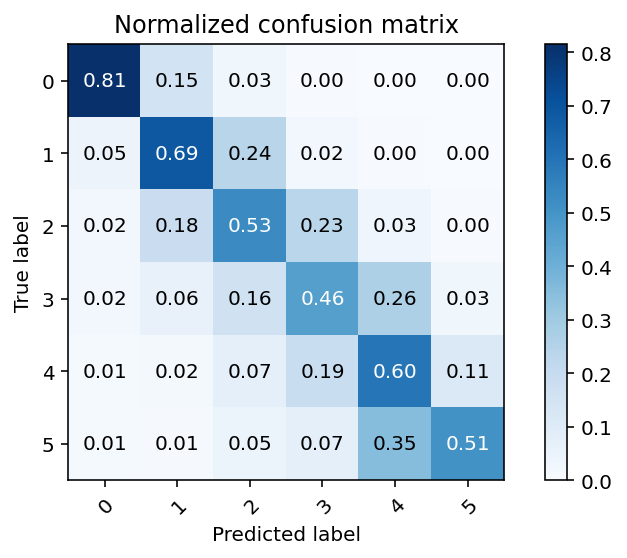

In [73]:
_ = plot_confusion_matrix(val_df.isup_grade, val_df.isup_pred, normalize=True)

In [74]:
logging.info(f"Models: {model_fnames}")

Models: ['09-07-2020-19-12_44_qwk.pth']


In [75]:
pred_kappa = cohen_kappa_score(val_df.isup_grade, val_df.isup_pred, weights="quadratic")

In [76]:
logging.info(f"Overall kapa: {pred_kappa}")

Overall kapa: 0.8795858745427514


In [77]:
karol_df = val_df[val_df.data_provider == "karolinska"].copy()
kapa_karol = cohen_kappa_score(karol_df.isup_grade, karol_df.isup_pred, weights="quadratic")
logging.info(f"Karolinska kapa: {kapa_karol}")

Karolinska kapa: 0.8719888564262599


In [78]:
radboud_df = val_df[val_df.data_provider == "radboud"].copy()
kapa_radboud = cohen_kappa_score(radboud_df.isup_grade, radboud_df.isup_pred, weights="quadratic")
logging.info(f"Radboud kapa: {kapa_radboud}")

Radboud kapa: 0.8569908685036535


#### Optimize Rounding

In [79]:
rnd_sample_ids = val_df.sample(frac=0.5).index

In [80]:
val_df["eval"] = 0
val_df.loc[rnd_sample_ids, "eval"] = 1

In [81]:
dev_preds = val_df.loc[val_df["eval"] == 0, "isup_raw_pred"].values
dev_targs = val_df.loc[val_df["eval"] == 0, "isup_grade"].values
eval_preds = val_df.loc[val_df["eval"] == 1, "isup_raw_pred"].values
eval_targs = val_df.loc[val_df["eval"] == 1, "isup_grade"].values

In [82]:
opt_r = OptimizedRounder()
opt_r.fit(dev_preds, dev_targs)

In [83]:
coefficients = opt_r.coefficients()
logging.info(f"Optimized coefs: {coefficients}")

Optimized coefs: [0.54811163 1.50420188 2.3605699  3.46926022 4.32291091]


In [84]:
eval_preds_round = opt_r.predict(val_df.isup_raw_pred, coefficients)

In [85]:
round_opt_kapa = cohen_kappa_score(val_df.isup_grade, eval_preds_round, weights="quadratic")

In [86]:
logging.info(f"Optimized round kapa: {round_opt_kapa}")

Optimized round kapa: 0.8807311139521619


#### Check results with Hard Class Permutation

In [43]:
hard_cls_values = val_df.loc[val_df.isup_pred.isin([2,3,4]), "isup_pred"].copy().values

In [44]:
hard_cls_values[:5]

array([4, 3, 4, 2, 3])

In [45]:
np.random.shuffle(hard_cls_values)

In [46]:
hard_cls_values[:5]

array([3, 4, 3, 4, 2])

In [47]:
val_df.loc[val_df.isup_pred.isin([2,3,4]), "isup_pred"] = hard_cls_values

Normalized confusion matrix
[[0.94382022 0.03792135 0.00702247 0.00421348 0.00280899 0.00421348]
 [0.0830721  0.79937304 0.03605016 0.04702194 0.03291536 0.0015674 ]
 [0.04126984 0.27936508 0.25396825 0.22222222 0.18412698 0.01904762]
 [0.09310345 0.05862069 0.26896552 0.23793103 0.24482759 0.09655172]
 [0.0652921  0.03780069 0.26460481 0.25429553 0.2371134  0.14089347]
 [0.05818182 0.01454545 0.11636364 0.10545455 0.14909091 0.55636364]]


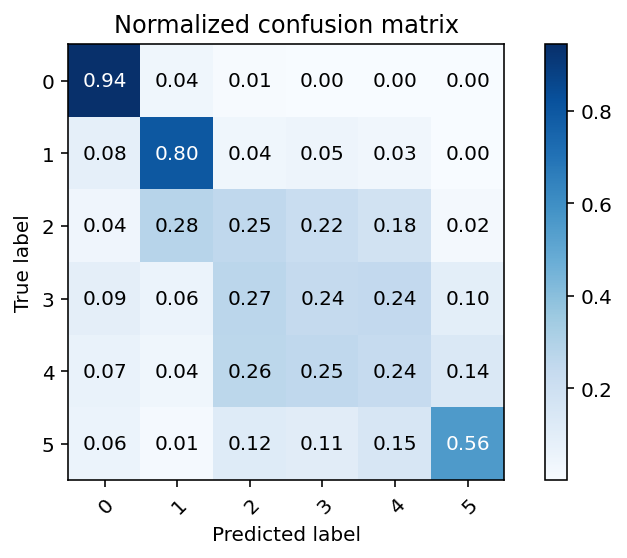

In [48]:
_ = plot_confusion_matrix(val_df.isup_grade, val_df.isup_pred, normalize=True)

In [49]:
permute_kapa = cohen_kappa_score(val_df.isup_grade, val_df.isup_pred, weights="quadratic")
permute_kapa

0.7659439769237075

In [50]:
print(f"Permutation importance: {1 - (permute_kapa/pred_kappa)}")

Permutation importance: 0.07017338008015972


In [34]:
# LB
print(f"LB Permutation importance: {1 - (0.80/0.84)}")

LB Permutation importance: 0.04761904761904756
